# **GrocerGenius : AI-Based Supermarket Sales Prediction**

**Description**:
This project aims to predict the sales of various items at different supermarket outlets using historical sales data. The dataset contains information about items, outlets, and their sales figures. The objective is to build a predictive model that can forecast the sales of an item based on various features such as item type, outlet type, and item visibility.


# 1. **DATA OVERVIEW :**

Initial data structure, missing values, basic statistics

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce
from sklearn.preprocessing import LabelEncoder, StandardScaler, OrdinalEncoder, PowerTransformer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import ttest_ind, f_oneway, chi2_contingency
from scipy.stats import skew, kurtosis, pearsonr, spearmanr
from sklearn.linear_model import LinearRegression

## 1.1 **Data Loading**
We begin by loading the dataset and inspecting the first few rows.


In [2]:
# Load the dataset from the specified file path
# This loads the training data into a DataFrame for further analysis
df = pd.read_csv('/kaggle/input/master-train/Train.csv')

# Display the first few rows of the dataset to understand its structure
# This gives an overview of the data, including the column names and first entries
df.head()


Item_Identifier  Item_Weight Item_Fat_Content  Item_Visibility  \
0           FDA15         9.30          Low Fat         0.016047   
1           DRC01         5.92          Regular         0.019278   
2           FDN15        17.50          Low Fat         0.016760   
3           FDX07        19.20          Regular         0.000000   
4           NCD19         8.93          Low Fat         0.000000   

               Item_Type  Item_MRP Outlet_Identifier  \
0                  Dairy  249.8092            OUT049   
1            Soft Drinks   48.2692            OUT018   
2                   Meat  141.6180            OUT049   
3  Fruits and Vegetables  182.0950            OUT010   
4              Household   53.8614            OUT013   

   Outlet_Establishment_Year Outlet_Size Outlet_Location_Type  \
0                       1999      Medium               Tier 1   
1                       2009      Medium               Tier 3   
2                       1999      Medium               Tier 1   
3                       1998         NaN               Tier 3   
4                       1987        High               Tier 3   

         Outlet_Type  Item_Outlet_Sales  
0  Supermarket Type1          3735.1380  
1  Supermarket Type2           443.4228  
2  Supermarket Type1          2097.2700  
3      Grocery Store           732.3800  
4  Supermarket Type1           994.7052

## 1.2 **Data Structure**

Initial exploration of the dataset helps us understand the structure of the data, its dimensions, and any missing values.

Let's display the dataset and check for missing values:


In [3]:
# Check dimensions
print("Data Dimensions:", df.shape)

# List feature names and data types
print("Feature Names and Data Types:")
print(df.dtypes)


Data Dimensions: (8523, 12)
Feature Names and Data Types:
Item_Identifier               object
Item_Weight                  float64
Item_Fat_Content              object
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Outlet_Size                   object
Outlet_Location_Type          object
Outlet_Type                   object
Item_Outlet_Sales            float64
dtype: object


## 1.3 **Missing Values**

In [4]:
# Check for missing values
missing_values = df.isnull().sum()
print("Missing Values Per Column:")
print(missing_values[missing_values > 0])  # Display only columns with missing values


Missing Values Per Column:
Item_Weight    1463
Outlet_Size    2410
dtype: int64


**Observations**:
- The dataset contains 8523 rows and 12 columns.
- There are missing values in `Item_Weight` and `Outlet_Size`.

## 1.4 **Basic Statistics**

In [5]:
# List of categorical columns
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
categorical_cols

['Item_Identifier',
 'Item_Fat_Content',
 'Item_Type',
 'Outlet_Identifier',
 'Outlet_Size',
 'Outlet_Location_Type',
 'Outlet_Type']

In [6]:
# Value counts for categorical features
categorical_columns = df.select_dtypes(include=['object']).columns
for col in categorical_columns:
    print(f"\nValue Counts for {col}:")
    print(df[col].value_counts())


Value Counts for Item_Identifier:
Item_Identifier
FDW13    10
FDG33    10
NCY18     9
FDD38     9
DRE49     9
         ..
FDY43     1
FDQ60     1
FDO33     1
DRF48     1
FDC23     1
Name: count, Length: 1559, dtype: int64

Value Counts for Item_Fat_Content:
Item_Fat_Content
Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: count, dtype: int64

Value Counts for Item_Type:
Item_Type
Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: count, dtype: int64

Value Counts for Outlet_Identifier:
Outlet_Identifier
OUT027    935
OUT0

In [7]:
# List of numerical columns
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
numeric_cols

['Item_Weight',
 'Item_Visibility',
 'Item_MRP',
 'Outlet_Establishment_Year',
 'Item_Outlet_Sales']

In [8]:
# Summary statistics for numerical columns
print("Numerical Features Summary:")
print(df.describe())

Numerical Features Summary:
       Item_Weight  Item_Visibility     Item_MRP  Outlet_Establishment_Year  \
count  7060.000000      8523.000000  8523.000000                8523.000000   
mean     12.857645         0.066132   140.992782                1997.831867   
std       4.643456         0.051598    62.275067                   8.371760   
min       4.555000         0.000000    31.290000                1985.000000   
25%       8.773750         0.026989    93.826500                1987.000000   
50%      12.600000         0.053931   143.012800                1999.000000   
75%      16.850000         0.094585   185.643700                2004.000000   
max      21.350000         0.328391   266.888400                2009.000000   

       Item_Outlet_Sales  
count        8523.000000  
mean         2181.288914  
std          1706.499616  
min            33.290000  
25%           834.247400  
50%          1794.331000  
75%          3101.296400  
max         13086.964800  


# 2. **DATA CLEANING** :

## 2.1 **Handling Missing Values**

We will:
- Fill missing `Item_Weight` values by the median weight within each `Item_Type`.
- Fill missing `Outlet_Size` using the mode based on `Outlet_Type`.


In [9]:
# Impute missing Item_Weight
df['Item_Weight'] = df.groupby('Item_Type')['Item_Weight'].transform(lambda x: x.fillna(x.median()))

# Impute missing Outlet_Size
df['Outlet_Size'] = df.groupby('Outlet_Type')['Outlet_Size'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else 'Unknown'))

# Verify no missing values
def check_missing_values(df):
    missing = df.isnull().sum()
    if missing.sum() == 0:
        print("No missing values remaining.")
    else:
        print("Remaining missing values:\n", missing[missing > 0])

# After imputations
check_missing_values(df)

No missing values remaining.


## 2.2 **Zero-Visibility Handling**

In [10]:
# Replace zero visibility values with the median visibility
median_visibility = df[df['Item_Visibility'] > 0]['Item_Visibility'].median()
df['Item_Visibility'] = df['Item_Visibility'].replace(0, median_visibility)
print(f"Number of zero visibility values after replacement: {sum(df['Item_Visibility'] == 0)}")

Number of zero visibility values after replacement: 0


## 2.3 **Map values in Item_Fat_Content for consistency**

In [11]:
# Map values in Item_Fat_Content for consistency
fat_content_map = {
    'LF': 'Low Fat', 
    'low fat': 'Low Fat', 
    'Low Fat': 'Low Fat',
    'reg': 'Regular',
    'Regular' :'Regular'
}

df['Item_Fat_Content'] = df['Item_Fat_Content'].replace(fat_content_map)
print("Updated counts for Item_Fat_Content:\n", df['Item_Fat_Content'].value_counts())

Updated counts for Item_Fat_Content:
 Item_Fat_Content
Low Fat    5517
Regular    3006
Name: count, dtype: int64


## 2.4 **Outlier Detection and Mitigation**
We will use the Interquartile Range (IQR) method to detect outliers in continuous numerical features. Outliers are defined as values that fall below Q1 - 1.5 * IQR or above Q3 + 1.5 * IQR, where:

* Q1 is the first quartile (25th percentile).
* Q3 is the third quartile (75th percentile).
* IQR is the interquartile range, calculated as Q3 - Q1.

In [12]:
# Function to detect outliers using IQR
def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] < lower_bound) | (df[column] > upper_bound)]

# Checking for outliers in numerical columns
numerical_cols = ['Item_Weight','Item_Visibility', 'Item_MRP', 'Outlet_Establishment_Year', 'Item_Outlet_Sales']
outliers = {}

for col in numerical_cols:
    outliers[col] = detect_outliers_iqr(df, col)
    print(f"Outliers detected in {col}: {len(outliers[col])}")

Outliers detected in Item_Weight: 0
Outliers detected in Item_Visibility: 173
Outliers detected in Item_MRP: 0
Outliers detected in Outlet_Establishment_Year: 0
Outliers detected in Item_Outlet_Sales: 186


### Outlier Mitigation Strategy
We will use capping to mitigate the outliers. This involves replacing the outliers with the values at the lower and upper bounds defined by the IQR method. Capping prevents removing data points and maintains the size of the dataset.

In [13]:
#Function to Cap Outliers:
def cap_outliers(df, columns, factor=1.5):
    for column in columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - factor * IQR
        upper_bound = Q3 + factor * IQR
        df[column] = np.clip(df[column], lower_bound, upper_bound)

cap_outliers(df, numerical_cols)

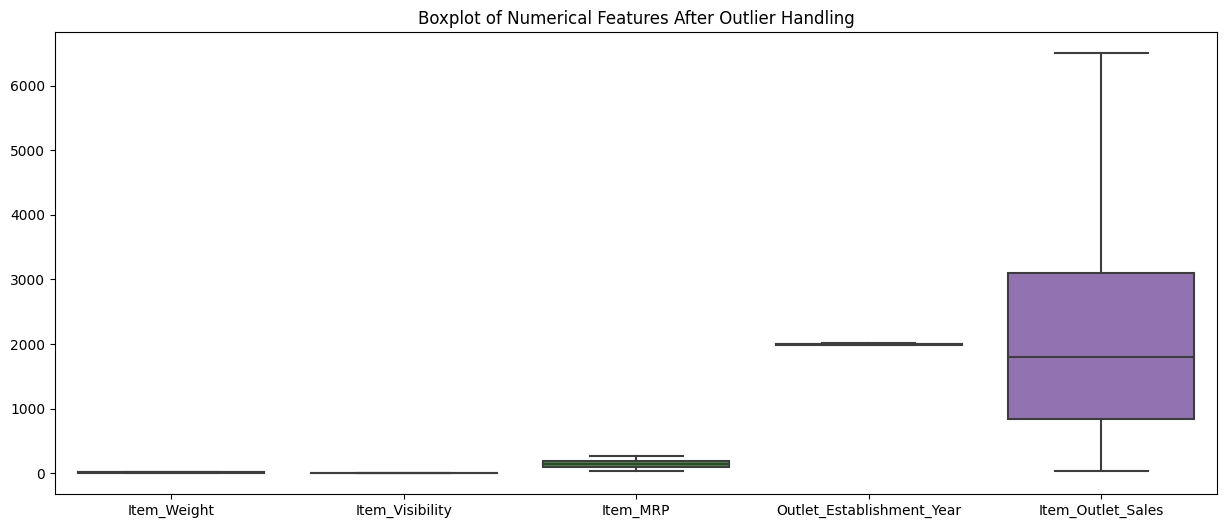

In [14]:
# Boxplot for numerical features
plt.figure(figsize=(15, 6))
sns.boxplot(data=df[numeric_cols])
plt.title("Boxplot of Numerical Features After Outlier Handling")
plt.show()


## 2.5 **Saving the Cleaned Data**

In [15]:
# Saved the cleaned data to a CSV file in the Kaggle notebook environment
cleaned_data_path = '/kaggle/working/clean_train_V1.csv'
df.to_csv(cleaned_data_path, index=False)
print(f"Cleaned dataset saved at {cleaned_data_path}")

Cleaned dataset saved at /kaggle/working/clean_train_V1.csv


# 3. **EXPLORATORY DATA ANALYSIS** :

We now explore the data to find patterns and relationships between different features and the target variable, `Item_Outlet_Sales`.



## 3.1 **Loading the Saved Data for EDA**

In [16]:
# Load the saved data for EDA
df_cleaned = pd.read_csv('/kaggle/working/clean_train_V1.csv')

# Display the first few rows of the cleaned data
df_cleaned.head()

Item_Identifier  Item_Weight Item_Fat_Content  Item_Visibility  \
0           FDA15         9.30          Low Fat         0.016047   
1           DRC01         5.92          Regular         0.019278   
2           FDN15        17.50          Low Fat         0.016760   
3           FDX07        19.20          Regular         0.057792   
4           NCD19         8.93          Low Fat         0.057792   

               Item_Type  Item_MRP Outlet_Identifier  \
0                  Dairy  249.8092            OUT049   
1            Soft Drinks   48.2692            OUT018   
2                   Meat  141.6180            OUT049   
3  Fruits and Vegetables  182.0950            OUT010   
4              Household   53.8614            OUT013   

   Outlet_Establishment_Year Outlet_Size Outlet_Location_Type  \
0                       1999      Medium               Tier 1   
1                       2009      Medium               Tier 3   
2                       1999      Medium               Tier 1   
3                       1998       Small               Tier 3   
4                       1987        High               Tier 3   

         Outlet_Type  Item_Outlet_Sales  
0  Supermarket Type1          3735.1380  
1  Supermarket Type2           443.4228  
2  Supermarket Type1          2097.2700  
3      Grocery Store           732.3800  
4  Supermarket Type1           994.7052

In [17]:
# Define categorical columns in the dataset
# These columns contain discrete values representing categories
categorical_cols = [
    'Item_Identifier',         # Unique identifier for each item
    'Item_Fat_Content',        # Fat content category (e.g., Low fat, Regular)
    'Item_Type',               # Type or category of the item (e.g., Dairy, Soft Drinks)
    'Outlet_Identifier',       # Unique identifier for each outlet/store
    'Outlet_Size',             # Size category of the outlet (e.g., Small, Medium, High)
    'Outlet_Location_Type',    # Type of location (e.g., Tier 1, Tier 2)
    'Outlet_Type'              # Type of outlet (e.g., Grocery Store, Supermarket)
]

# Define numeric columns in the dataset
# These columns contain continuous or discrete numerical values
numeric_cols = [
    'Item_Weight',             # Weight of the item
    'Item_Visibility',         # Visibility of the item in the store (0 means not visible)
    'Item_MRP',                # Maximum retail price of the item
    'Outlet_Establishment_Year',  # Year the outlet was established
    'Item_Outlet_Sales'        # Target variable: sales of the item in a specific outlet
]


## 3.2 **Univariate Analysis**

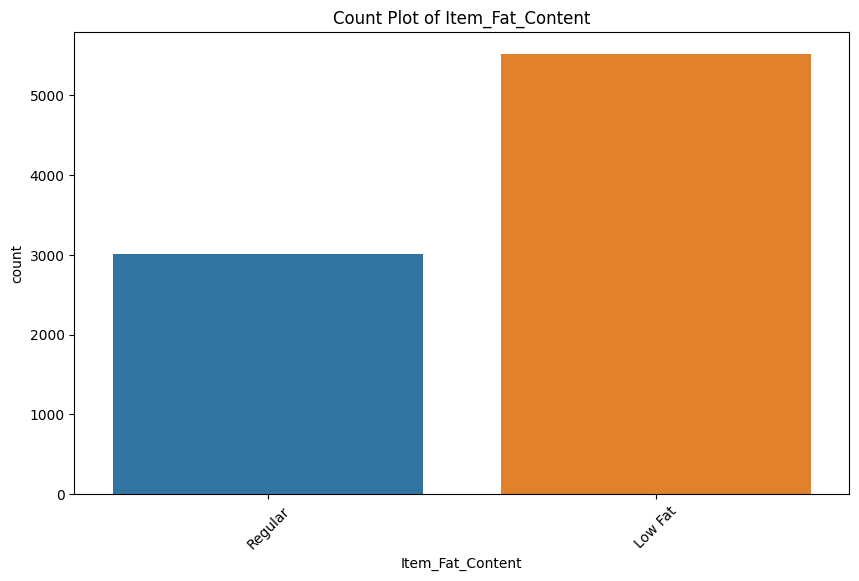

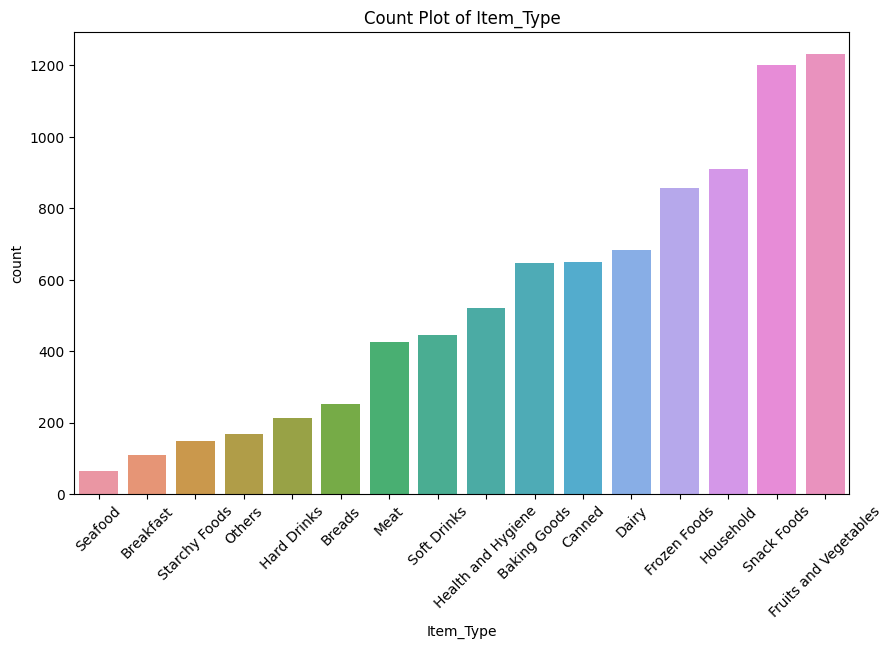

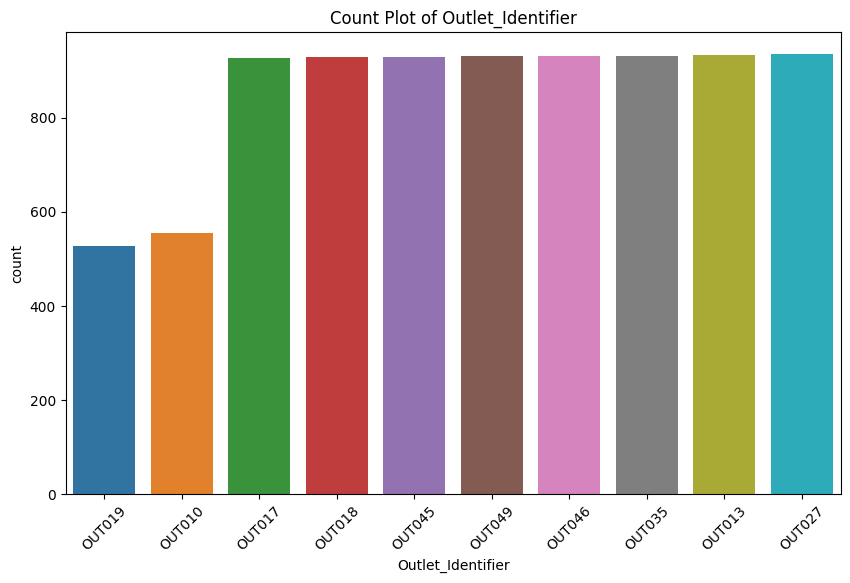

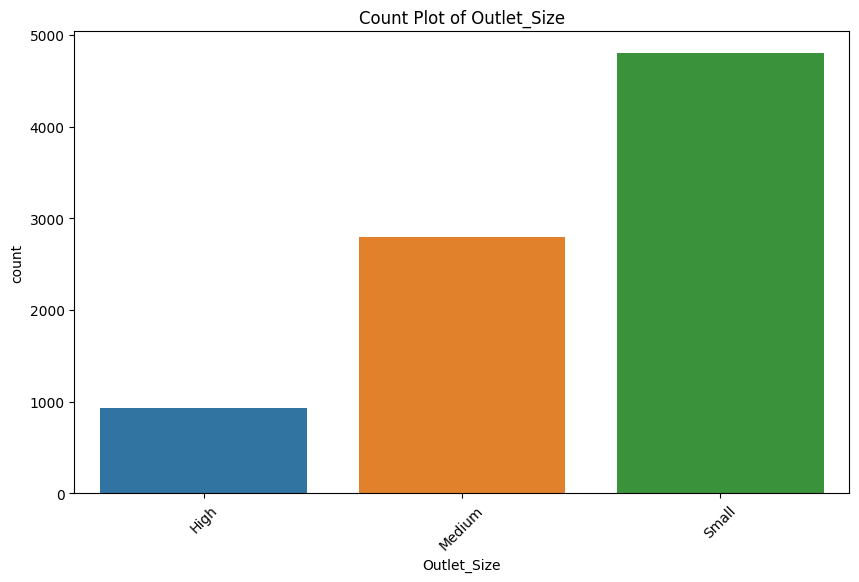

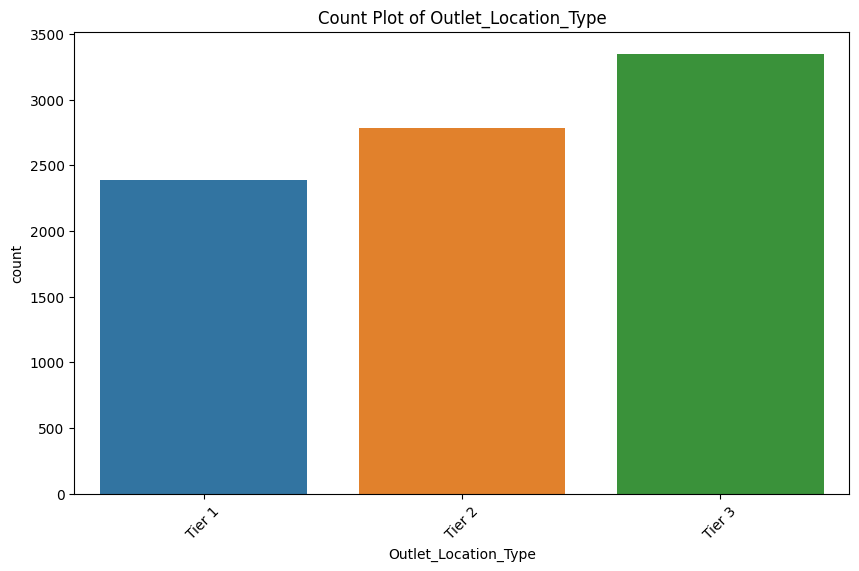

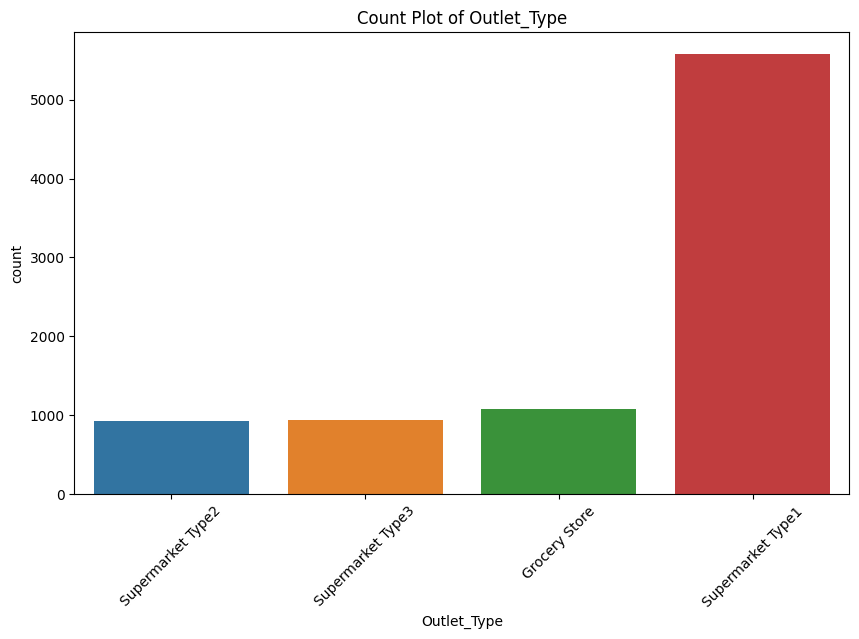

In [18]:
# Count plot for categorical columns
categorical_cols = [col for col in categorical_cols if col != 'Item_Identifier']


for col in categorical_cols:
    plt.figure(figsize=(10, 6))
    sorted_data = df_cleaned[col].value_counts().sort_values().index
    sns.countplot(x=col, data=df, order=sorted_data) 
    plt.title(f'Count Plot of {col}')
    plt.xticks(rotation=45)
    plt.show()

Item_Weight - Skewness: 0.12, Kurtosis: -0.89


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


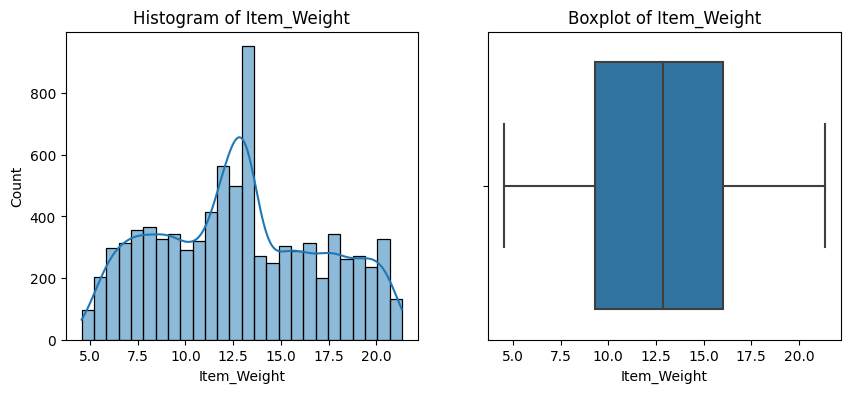

Item_Visibility - Skewness: 0.88, Kurtosis: -0.01


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


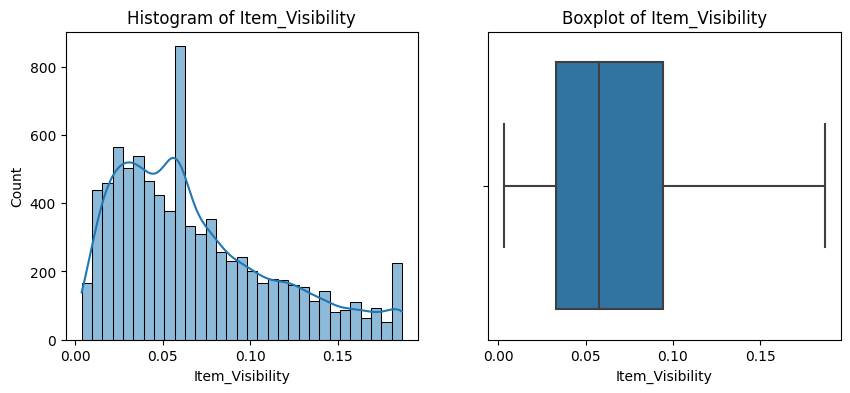

Item_MRP - Skewness: 0.13, Kurtosis: -0.89


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


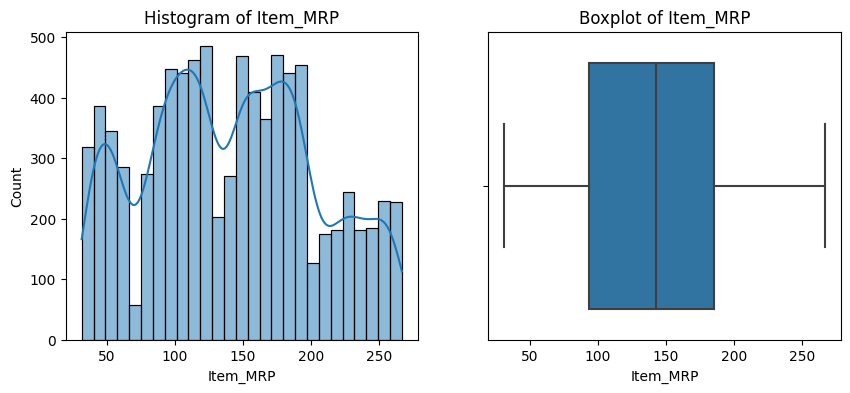

Outlet_Establishment_Year - Skewness: -0.40, Kurtosis: -1.21


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


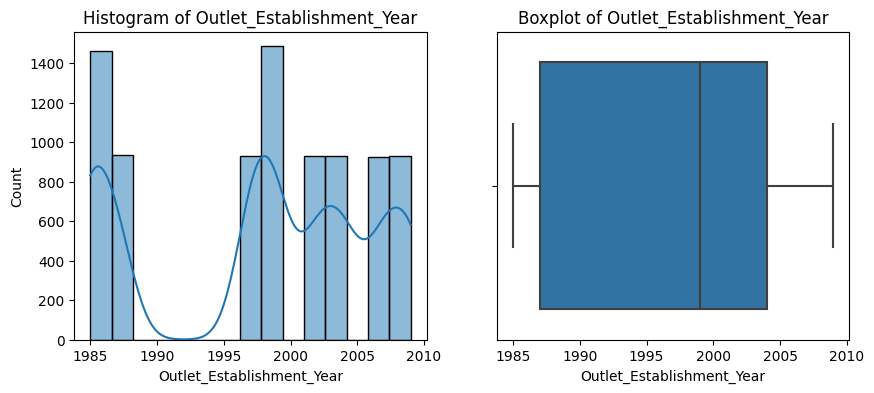

Item_Outlet_Sales - Skewness: 0.87, Kurtosis: 0.07


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


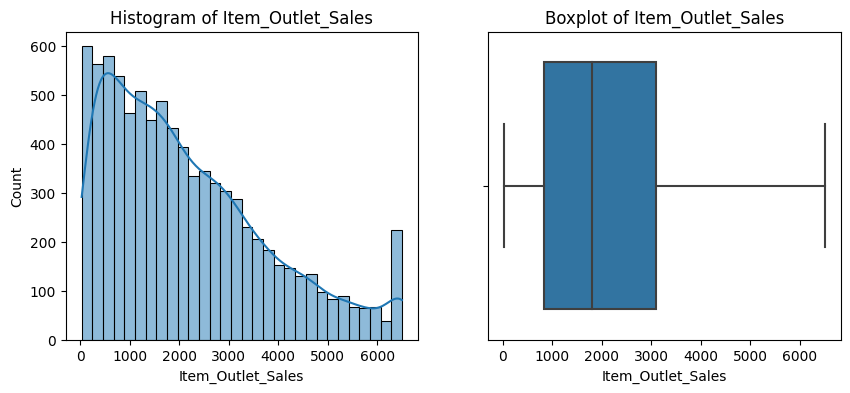

In [19]:
# Loop through numerical columns to plot histograms and boxplots
for col in numeric_cols:
    # Print skewness and kurtosis
    skewness = skew(df_cleaned[col].dropna())
    kurt = kurtosis(df_cleaned[col].dropna())
    print(f"{col} - Skewness: {skewness:.2f}, Kurtosis: {kurt:.2f}")

    # Histogram and Boxplot
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    sns.histplot(df_cleaned[col], kde=True)
    plt.title(f'Histogram of {col}')
    
    plt.subplot(1, 2, 2)
    sns.boxplot(x=df_cleaned[col])
    plt.title(f'Boxplot of {col}')
    plt.show()


## 3.3 **Bivariate Analysis**

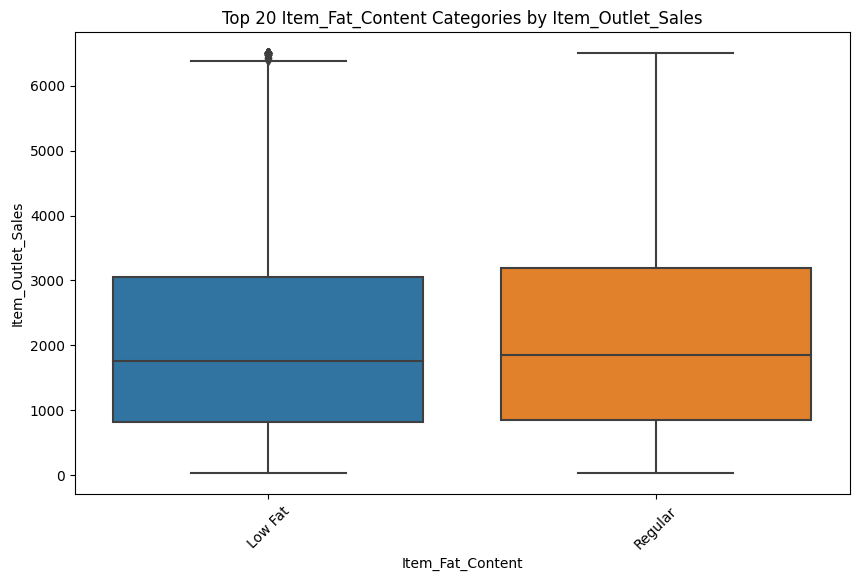

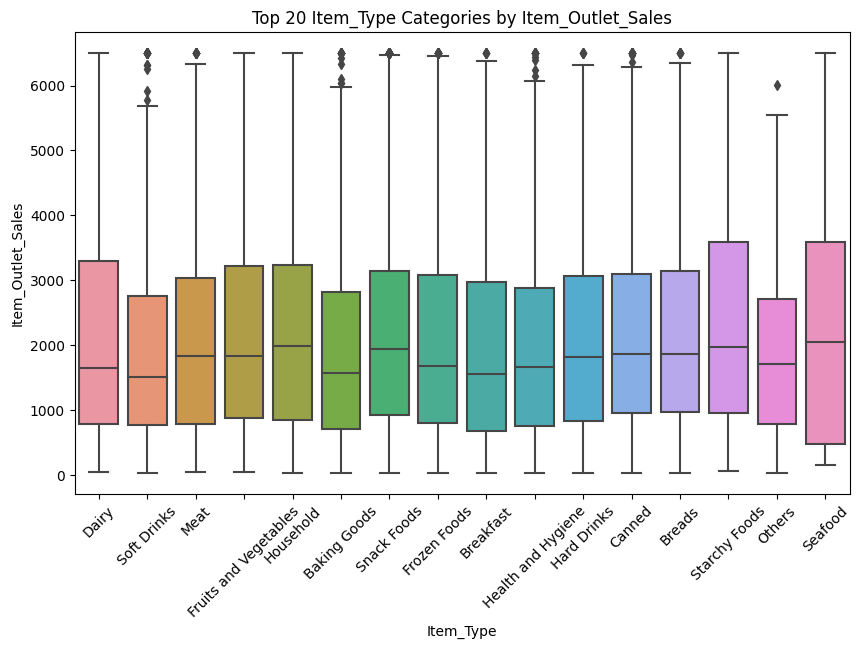

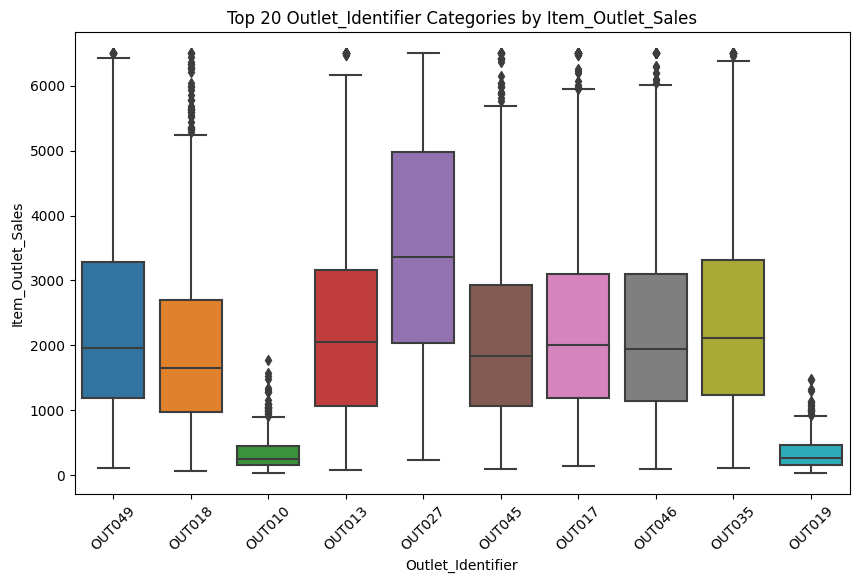

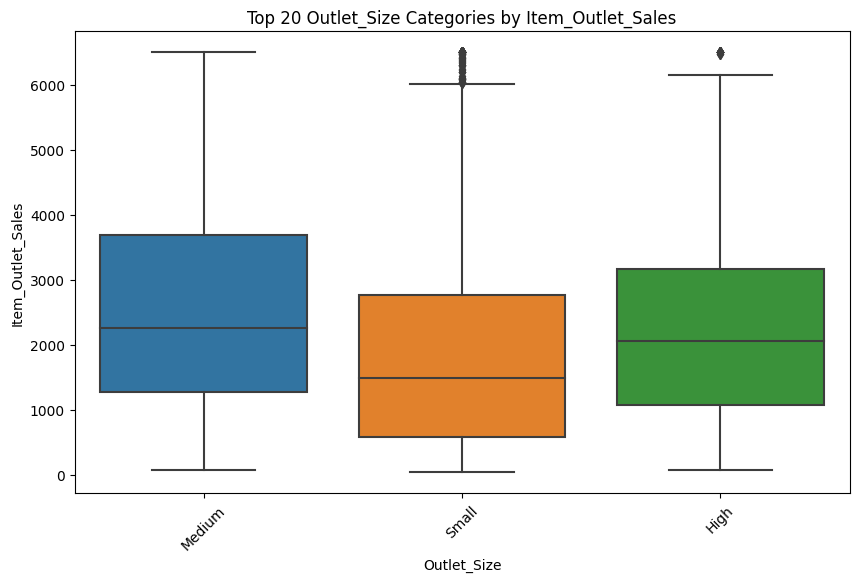

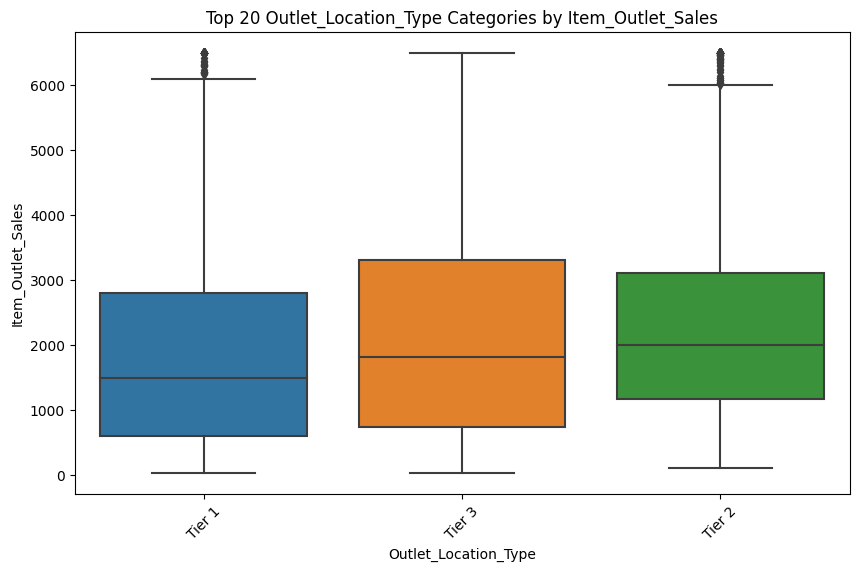

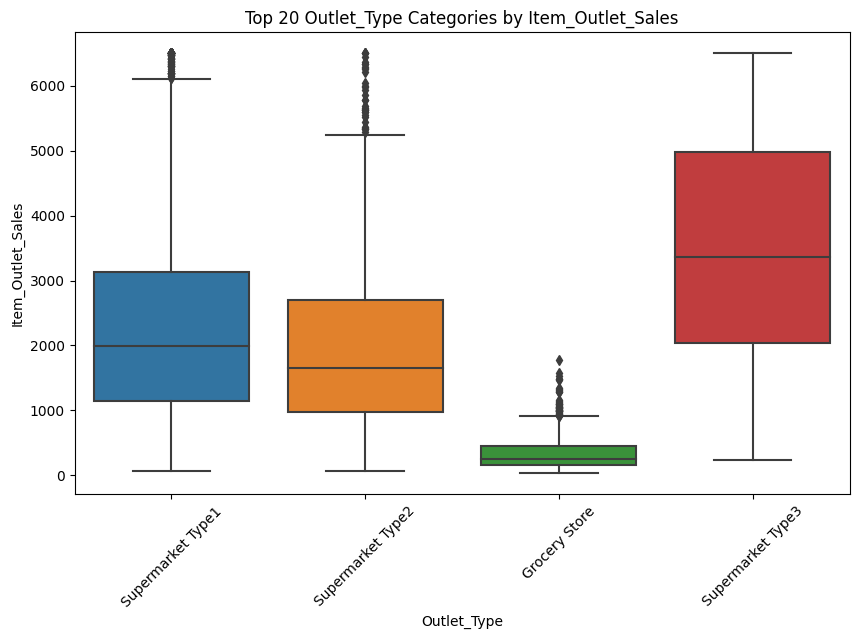

In [20]:
# Define the number of top categories to display
top_n = 20  

for col in categorical_cols:
    # Calculate mean sales for each category
    mean_sales_by_category = df_cleaned.groupby(col)['Item_Outlet_Sales'].mean().sort_values(ascending=False)
    top_categories = mean_sales_by_category.head(top_n).index  # Select top N categories
    
    # Filter the dataset to include only the top categories
    df_top_categories = df_cleaned[df_cleaned[col].isin(top_categories)]
    
    # Box Plot for Top N Categories
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df_top_categories, x=col, y='Item_Outlet_Sales')
    plt.xticks(rotation=45)
    plt.title(f"Top {top_n} {col} Categories by Item_Outlet_Sales")
    plt.show()
    
   

## 3.4 **Multivariate Analysis**

In [21]:
# Loop through each categorical column and conduct ANOVA
for col in categorical_cols:
    groups = [df_cleaned['Item_Outlet_Sales'][df_cleaned[col] == cat] for cat in df_cleaned[col].unique()]
    anova_result = f_oneway(*groups)
    print(f"ANOVA test for {col} with Item_Outlet_Sales: p-value = {anova_result.pvalue}")


ANOVA test for Item_Fat_Content with Item_Outlet_Sales: p-value = 0.06932135628769576
ANOVA test for Item_Type with Item_Outlet_Sales: p-value = 0.0004033662336460725
ANOVA test for Outlet_Identifier with Item_Outlet_Sales: p-value = 0.0
ANOVA test for Outlet_Size with Item_Outlet_Sales: p-value = 9.557919648855579e-91
ANOVA test for Outlet_Location_Type with Item_Outlet_Sales: p-value = 5.083523155806247e-24
ANOVA test for Outlet_Type with Item_Outlet_Sales: p-value = 0.0


* ANOVA Test Results:

* Item_Fat_Content
* p-value: 0.0693
* Interpretation: Not statistically significant at the typical alpha level (0.05), suggesting that Item_Fat_Content does not have a strong impact on Item_Outlet_Sales.

* Item_Type
* p-value: 0.0004
* Interpretation: Highly significant, indicating that different Item_Types have a significant effect on Item_Outlet_Sales.

* Outlet_Identifier
* p-value: 0.0
* Interpretation: Extremely significant, suggesting a strong relationship between Outlet_Identifier and Item_Outlet_Sales.

* Outlet_Size
* p-value: 9.56e-91
* Interpretation: Highly significant, indicating that Outlet_Size has a strong effect on Item_Outlet_Sales.

* Outlet_Location_Type
* p-value: 5.08e-24
* Interpretation: Highly significant, indicating a strong relationship with Item_Outlet_Sales.

* Outlet_Type
* p-value: 0.0
* Interpretation: Extremely significant, suggesting that Outlet_Type significantly affects Item_Outlet_Sales.

In [22]:
# Chi-Square Test for categorical features (e.g., Outlet_Size vs Outlet_Location_Type)
contingency_table = pd.crosstab(df_cleaned['Outlet_Size'], df_cleaned['Outlet_Location_Type'])
chi2, p_val, _, _ = chi2_contingency(contingency_table)
print(f"Chi-Square Test: Outlet_Size vs Outlet_Location_Type: chi2 = {chi2}, p-value = {p_val}")

# Chi-Square Test between Outlet_Size and Item_Fat_Content
contingency_table = pd.crosstab(df_cleaned['Outlet_Size'], df_cleaned['Item_Fat_Content'])
chi2, p_val, _, _ = chi2_contingency(contingency_table)
print(f"Chi-Square Test: Outlet_Size vs Item_Fat_Content: chi3 = {chi2}, p-value = {p_val}")

# Chi-Square Test between Item_Type and Item_Fat_Content
contingency_table = pd.crosstab(df_cleaned['Item_Type'], df_cleaned['Item_Fat_Content'])
chi2, p_val, _, _ = chi2_contingency(contingency_table)
print(f"Chi-Square Test: Item_Type vs Item_Fat_Content: chi2 = {chi2}, p-value = {p_val}")

Chi-Square Test: Outlet_Size vs Outlet_Location_Type: chi2 = 4806.778592709207, p-value = 0.0
Chi-Square Test: Outlet_Size vs Item_Fat_Content: chi3 = 0.19486190434458034, p-value = 0.9071649771643981
Chi-Square Test: Item_Type vs Item_Fat_Content: chi2 = 1509.0010155480727, p-value = 0.0


* Chi-Square Test Results

* Outlet_Size vs Outlet_Location_Type
* chi2: 4806.78
* p-value: 0.0
* Interpretation: Strong association between Outlet_Size and Outlet_Location_Type.

* Outlet_Size vs Item_Fat_Content
* chi2: 0.1949
* p-value: 0.9072
* Interpretation: Not statistically significant, indicating no strong relationship between Outlet_Size and Item_Fat_Content.

* Item_Type vs Item_Fat_Content
* chi2: 1509.00
* p-value: 0.0
* Interpretation: Strong association, indicating a significant relationship between Item_Type and Item_Fat_Content.

# 4. **FEATURE DERIVATION & TRANSFORMATION :**

## 4.1 **Feature Derivation**

In [23]:
# Feature Engineering: Creating new features to capture more information

# Calculate the age of the outlet by subtracting the establishment year from the current year
df_cleaned['Outlet_Age'] = 2024 - df['Outlet_Establishment_Year']

# Create a combined feature for 'Outlet_Type' and 'Outlet_Location_Type'
# This captures the relationship between the type and location of each outlet
df_cleaned['Outlet_Type_Location'] = df_cleaned['Outlet_Type'].astype(str) + '_' + df_cleaned['Outlet_Location_Type'].astype(str)

# Create a combined feature for 'Item_Type' and 'Outlet_Type'
# This feature captures interactions between item types and outlet types
df_cleaned['Item_Outlet_Type'] = df_cleaned['Item_Type'].astype(str) + '_' + df_cleaned['Outlet_Type'].astype(str)

# Create a combined feature for 'Item_Fat_Content' and 'Item_Type'
# This feature captures the relationship between fat content and item type
df_cleaned['FatContent_ItemType'] = df_cleaned['Item_Fat_Content'].astype(str) + '_' + df_cleaned['Item_Type'].astype(str)

# Calculate the product of 'Item_Visibility' and 'Item_MRP'
# This feature highlights any influence of visibility and pricing on sales
df_cleaned['Visibility_MRP'] = df_cleaned['Item_Visibility'] * df_cleaned['Item_MRP']

# Create a combined feature for 'Item_Type' and 'Outlet_Location_Type'
# This captures interactions between item types and outlet location types
df_cleaned['Item_Location_Type'] = df_cleaned['Item_Type'].astype(str) + '_' + df_cleaned['Outlet_Location_Type'].astype(str)



## 4.2 **Feature Transformations**

In [24]:
# import numpy as np
# skewed_features = ['Outlet_Identifier', 'Item_Type']  # Add other skewed features if needed
# df_cleaned[skewed_features] = df_cleaned[skewed_features].apply(lambda x: np.log1p(x))

# 5. **FEATURE ENCODING & SCALING :**

## 5.1 **Feature Encoding**

In [25]:
# Import necessary libraries
import category_encoders as ce
from sklearn.preprocessing import OrdinalEncoder

# Target Encoding for selected interaction features
# Using TargetEncoder to encode features based on their correlation with 'Item_Outlet_Sales'
target_encoder = ce.TargetEncoder(cols=['Outlet_Type_Location', 'Item_Outlet_Type', 'Item_Location_Type', 'FatContent_ItemType'])
df_cleaned[['Outlet_Type_Location', 'Item_Outlet_Type', 'Item_Location_Type', 'FatContent_ItemType']] = target_encoder.fit_transform(
    df_cleaned[['Outlet_Type_Location', 'Item_Outlet_Type', 'Item_Location_Type', 'FatContent_ItemType']], df_cleaned['Item_Outlet_Sales']
)

# Frequency Encoding for 'Outlet_Type_Location' based on occurrence frequency
# Mapping each category in 'Outlet_Type_Location' to its frequency count
freq_outlet_type_location = df_cleaned['Outlet_Type_Location'].value_counts()
df_cleaned['Outlet_Type_Location'] = df_cleaned['Outlet_Type_Location'].map(freq_outlet_type_location)

# Target Encoding for high-cardinality identifiers
# Encoding 'Item_Identifier' and 'Outlet_Identifier' based on their mean target values
target_encoder = ce.TargetEncoder(cols=['Item_Identifier', 'Outlet_Identifier'])
df_cleaned[['Item_Identifier', 'Outlet_Identifier']] = target_encoder.fit_transform(
    df_cleaned[['Item_Identifier', 'Outlet_Identifier']], df_cleaned['Item_Outlet_Sales']
)

# Leave-One-Out Encoding for features with moderate correlation
# Applying Leave-One-Out encoding to 'Item_Type' and 'Outlet_Type' to reduce overfitting
loo_encoder = ce.LeaveOneOutEncoder(cols=['Item_Type'])
df_cleaned['Item_Type'] = loo_encoder.fit_transform(df_cleaned['Item_Type'], df_cleaned['Item_Outlet_Sales'])

loo_encoder = ce.LeaveOneOutEncoder(cols=['Outlet_Type'])
df_cleaned['Outlet_Type'] = loo_encoder.fit_transform(df_cleaned['Outlet_Type'], df_cleaned['Item_Outlet_Sales'])

# Encoding Ordinal Features in 'Item_Fat_Content', 'Outlet_Size', and 'Outlet_Location_Type'
# Mapping categories to ordinal values based on their natural or business hierarchy
ordinal_features = ['Item_Fat_Content', 'Outlet_Size', 'Outlet_Location_Type']
encoder = OrdinalEncoder(categories=[
    ['Low fat', 'Regular'],               # Item_Fat_Content hierarchy
    ['Small', 'Medium', 'High'],          # Outlet_Size hierarchy
    ['Tier 3', 'Tier 2', 'Tier 1']        # Outlet_Location_Type hierarchy
], handle_unknown='use_encoded_value', unknown_value=-1)

# Transform the ordinal features
df_cleaned[ordinal_features] = encoder.fit_transform(df_cleaned[ordinal_features])

# Display the resulting DataFrame after all encoding transformations
print("Resulting DataFrame after encoding transformations:")
print(df_cleaned.head())


Resulting DataFrame after encoding transformations:
   Item_Identifier  Item_Weight  Item_Fat_Content  Item_Visibility  \
0      2860.403689         9.30              -1.0         0.016047   
1      1900.318787         5.92               1.0         0.019278   
2      2011.058374        17.50              -1.0         0.016760   
3      2327.375385        19.20               1.0         0.057792   
4      1859.116771         8.93              -1.0         0.057792   

     Item_Type  Item_MRP  Outlet_Identifier  Outlet_Establishment_Year  \
0  2178.983018  249.8092        2341.687686                       1999   
1  1979.914502   48.2692        1994.847647                       2009   
2  2137.336556  141.6180        2341.687686                       1999   
3  2254.723046  182.0950         339.351662                       1998   
4  2236.146798   53.8614        2286.061090                       1987   

   Outlet_Size  Outlet_Location_Type  Outlet_Type  Item_Outlet_Sales  \
0         

## 5.2 **Feature Scaling**

In [26]:
# Define numerical features
numerical_features = ['Item_Weight', 'Outlet_Age', 'Item_Visibility', 'Item_MRP']

# Standardization
scaler = StandardScaler()
df_cleaned[numerical_features] = scaler.fit_transform(df_cleaned[numerical_features])

## 5.3 **Correlation Analysis and Feature Importance**

### 5.3.1 **Correlation Heatmap**

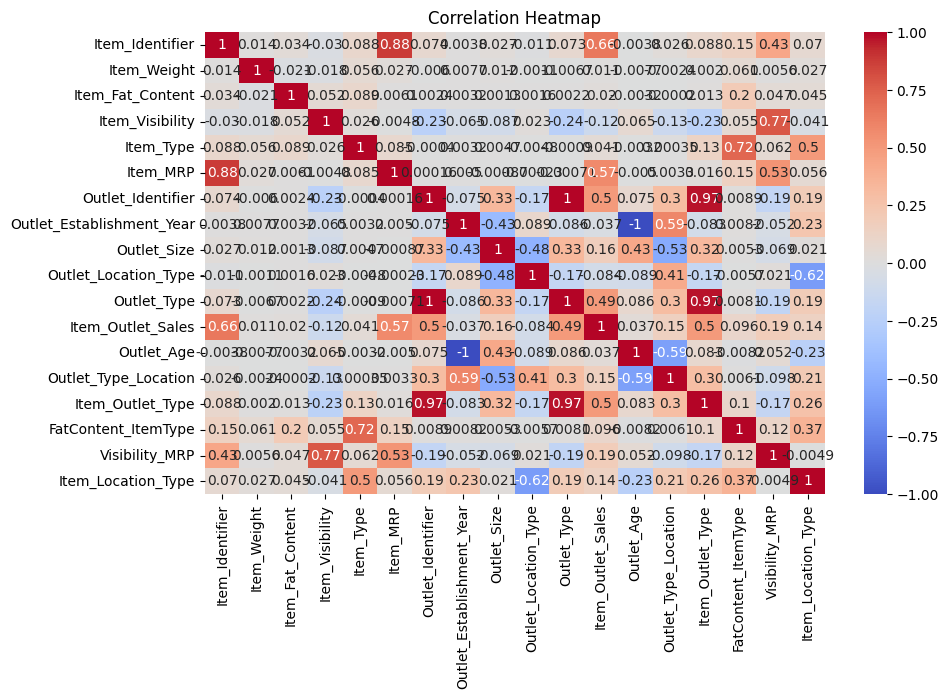

In [27]:
# correlation heatmap
plt.figure(figsize=(10, 6))
numeric_cols = df_cleaned.select_dtypes(include=['int64', 'float64']).columns
sns.heatmap(df_cleaned[numeric_cols].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

* Top Positive Correlations:
* Item_Identifier (0.655) and Item_MRP (0.575) have the highest positive correlation with Item_Outlet_Sales.
* Outlet_Age_Type, Item_Outlet_Type, and Outlet_Type also show moderate positive correlations (0.49 - 0.50 range).
* Low/Negative Correlations:
* Features like Item_Visibility (-0.123) and Outlet_Location_Type (-0.084) show weak negative correlations.

### 5.3.2 **Correlation with Target (Item Outlet Sales)**

In [28]:
# Store results in a dictionary
results = {}

# Check relationships for each numeric feature
for col in numeric_cols:
    # Calculate Pearson correlation for linearity
    pearson_corr, _ = pearsonr(df_cleaned[col].dropna(), df_cleaned['Item_Outlet_Sales'].dropna())
    
    # Calculate Spearman correlation for monotonic (non-linear) relationships
    spearman_corr, _ = spearmanr(df_cleaned[col].dropna(), df_cleaned['Item_Outlet_Sales'].dropna())

    # Fit a simple linear regression
    X = df_cleaned[[col]].dropna()
    y = df_cleaned['Item_Outlet_Sales'].dropna()
    linear_model = LinearRegression()
    linear_model.fit(X, y)
    linear_r2 = linear_model.score(X, y)

    # Fit a polynomial regression of degree 2 (quadratic)
    poly = PolynomialFeatures(degree=2)
    X_poly = poly.fit_transform(X)
    poly_model = LinearRegression()
    poly_model.fit(X_poly, y)
    poly_r2 = poly_model.score(X_poly, y)
    
    # Save results for comparison
    results[col] = {
        'Pearson Correlation': pearson_corr,
        'Spearman Correlation': spearman_corr,
        'Linear R-squared': linear_r2,
        'Quadratic R-squared': poly_r2,
    }

# Display results
import pandas as pd
results_df = pd.DataFrame(results).T
results_df


Pearson Correlation  Spearman Correlation  \
Item_Identifier                       0.655190              0.641623   
Item_Weight                           0.011033              0.012523   
Item_Fat_Content                      0.019675              0.018763   
Item_Visibility                      -0.123262             -0.120531   
Item_Type                             0.041214             -0.043371   
Item_MRP                              0.574554              0.562974   
Outlet_Identifier                     0.496407              0.446361   
Outlet_Establishment_Year            -0.037133              0.043058   
Outlet_Size                           0.164868              0.208470   
Outlet_Location_Type                 -0.083727             -0.063175   
Outlet_Type                           0.494317              0.026014   
Item_Outlet_Sales                     1.000000              1.000000   
Outlet_Age                            0.037133             -0.043058   
Outlet_Type_Location                  0.151130              0.309641   
Item_Outlet_Type                      0.496250              0.457773   
FatContent_ItemType                   0.095892              0.094319   
Visibility_MRP                        0.186401              0.225697   
Item_Location_Type                    0.136807              0.146394   

                           Linear R-squared  Quadratic R-squared  
Item_Identifier                    0.429274             0.429292  
Item_Weight                        0.000122             0.001343  
Item_Fat_Content                   0.000387             0.000387  
Item_Visibility                    0.015194             0.020865  
Item_Type                          0.001699             0.002108  
Item_MRP                           0.330112             0.330672  
Outlet_Identifier                  0.246420             0.246420  
Outlet_Establishment_Year          0.001379             0.007306  
Outlet_Size                        0.027182             0.047492  
Outlet_Location_Type               0.007010             0.012512  
Outlet_Type                        0.244350             0.244351  
Item_Outlet_Sales                  1.000000             1.000000  
Outlet_Age                         0.001379             0.007306  
Outlet_Type_Location               0.022840             0.082414  
Item_Outlet_Type                   0.246264             0.246272  
FatContent_ItemType                0.009195             0.009206  
Visibility_MRP                     0.034745             0.061340  
Item_Location_Type                 0.018716             0.018716

### 5.3.3 **Mutual Information Scores**

In [29]:
from sklearn.feature_selection import mutual_info_regression

# Define the feature set X and target variable y
# X contains all columns except 'Item_Outlet_Sales', while y is the target variable
X = df_cleaned.drop(columns=['Item_Outlet_Sales'])
y = df_cleaned['Item_Outlet_Sales']

# Calculate the mutual information scores between each feature in X and the target variable y
mi = mutual_info_regression(X, y)

# Create a pandas Series to hold the mutual information scores with feature names as the index
mi_scores = pd.Series(mi, index=X.columns)

# Sort the mutual information scores in descending order to identify the most informative features
mi_scores = mi_scores.sort_values(ascending=False)

# Print the mutual information scores to understand the relationship between features and the target variable
print("Mutual Information Scores:\n", mi_scores)

Mutual Information Scores:
 Outlet_Type                  2.330553
Item_Type                    1.851113
Item_MRP                     0.770872
Item_Identifier              0.391375
Item_Outlet_Type             0.299220
Outlet_Type_Location         0.265220
Outlet_Identifier            0.250551
Outlet_Establishment_Year    0.158058
Outlet_Age                   0.155418
Visibility_MRP               0.106582
Item_Visibility              0.081320
Item_Weight                  0.064538
Item_Location_Type           0.062753
FatContent_ItemType          0.059906
Outlet_Size                  0.039142
Outlet_Location_Type         0.037700
Item_Fat_Content             0.021265
dtype: float64


* Strong Predictors: Outlet_Type, Item_Type, and Item_MRP show the highest relevance for predicting Item_Outlet_Sales.
* Moderate Predictors: Item_Identifier, Outlet_Age_Type, and Item_Outlet_Type have moderate predictive power.
* Weak Predictors: Item_Visibility, Item_Weight, and Outlet_Size show low mutual information, suggesting limited predictive value individually.
* Lowest Relevance: Item_Fat_Content and Outlet_Age_Binned have minimal impact and could be considered for exclusion.

### 5.3.4 **Clustering and Dimensionality Reduction (PCA, t-SNE)**

### **PCA**

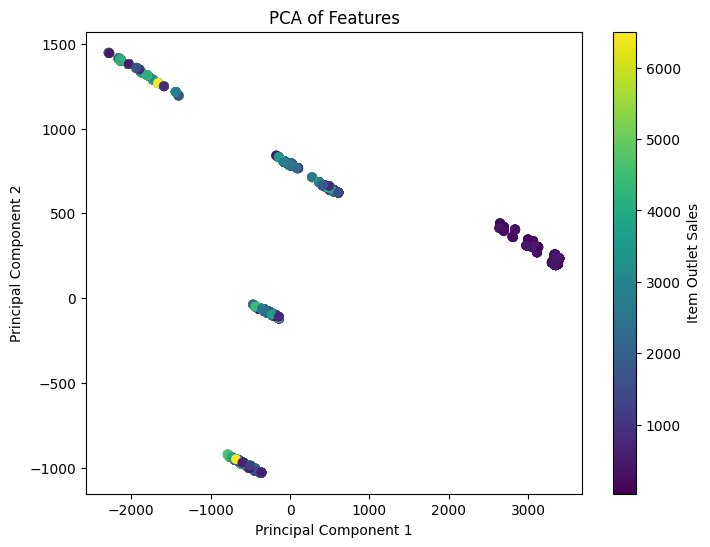

In [30]:
# Import the PCA class from sklearn.decomposition
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Instantiate the PCA object, specifying the number of components to reduce to
pca = PCA(n_components=2)

# Fit the PCA model to the feature set X and transform the data into principal components
X_pca = pca.fit_transform(X)

# Visualizing the PCA results
# Set up the figure size for the plot
plt.figure(figsize=(8, 6))

# Create a scatter plot of the first two principal components
# Color the points based on the 'Item_Outlet_Sales' values
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df_cleaned['Item_Outlet_Sales'], cmap='viridis')

# Add titles and labels to the plot
plt.title("PCA of Features")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")

# Add a color bar to indicate the scale of 'Item Outlet Sales'
plt.colorbar(label='Item Outlet Sales')

# Display the plot
plt.show()

* Distinct Clusters: The PCA plot shows several distinct clusters, suggesting that the data points can be grouped based on the reduced feature dimensions, indicating potential categorical separations or unique combinations of features.
* Item Outlet Sales Color Gradient: Higher Item_Outlet_Sales values (yellow) are spread across clusters but appear more concentrated in specific areas, which may suggest that certain feature combinations influence higher sales.
* Separation Along Components: The clear separation along Principal Component 1 and Principal Component 2 indicates that these components effectively capture key variance in the data.

### **t-SNE**

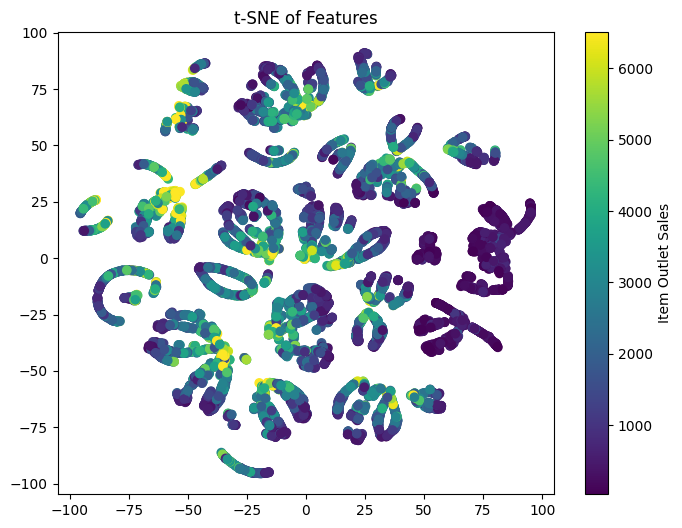

In [31]:
# Import the t-SNE class from sklearn.manifold
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Instantiate the t-SNE object, specifying the number of components to reduce to and a random seed for reproducibility
tsne = TSNE(n_components=2, random_state=42)

# Fit the t-SNE model to the feature set X and transform the data into two dimensions
X_tsne = tsne.fit_transform(X)

# Visualizing the t-SNE results
# Set up the figure size for the plot
plt.figure(figsize=(8, 6))

# Create a scatter plot of the two t-SNE components
# Color the points based on the 'Item_Outlet_Sales' values
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=df_cleaned['Item_Outlet_Sales'], cmap='viridis')

# Add a title to the plot
plt.title("t-SNE of Features")

# Add a color bar to indicate the scale of 'Item Outlet Sales'
plt.colorbar(label='Item Outlet Sales')

# Display the plot
plt.show()

* Complex Structure: The t-SNE plot reveals intricate clusters and patterns, highlighting non-linear relationships and dependencies within the data.
* Sales Value Patterns: Higher Item_Outlet_Sales values (in yellow) are scattered across clusters but tend to concentrate in certain areas, indicating specific combinations of features may be linked to higher sales.
* Cluster Diversity: The variety of shapes and dispersions suggests that different subsets of features contribute unique information, which might be leveraged for segmentation or targeted modeling.

## 5.3.5 **linear and non-linear fits**

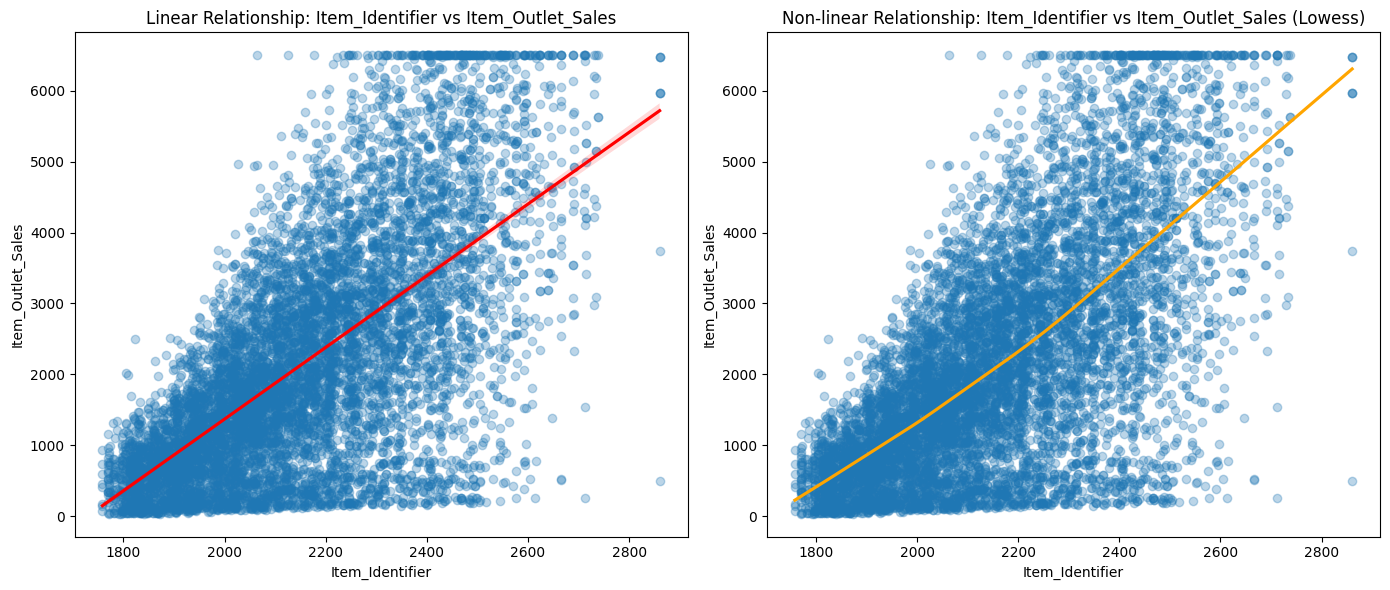

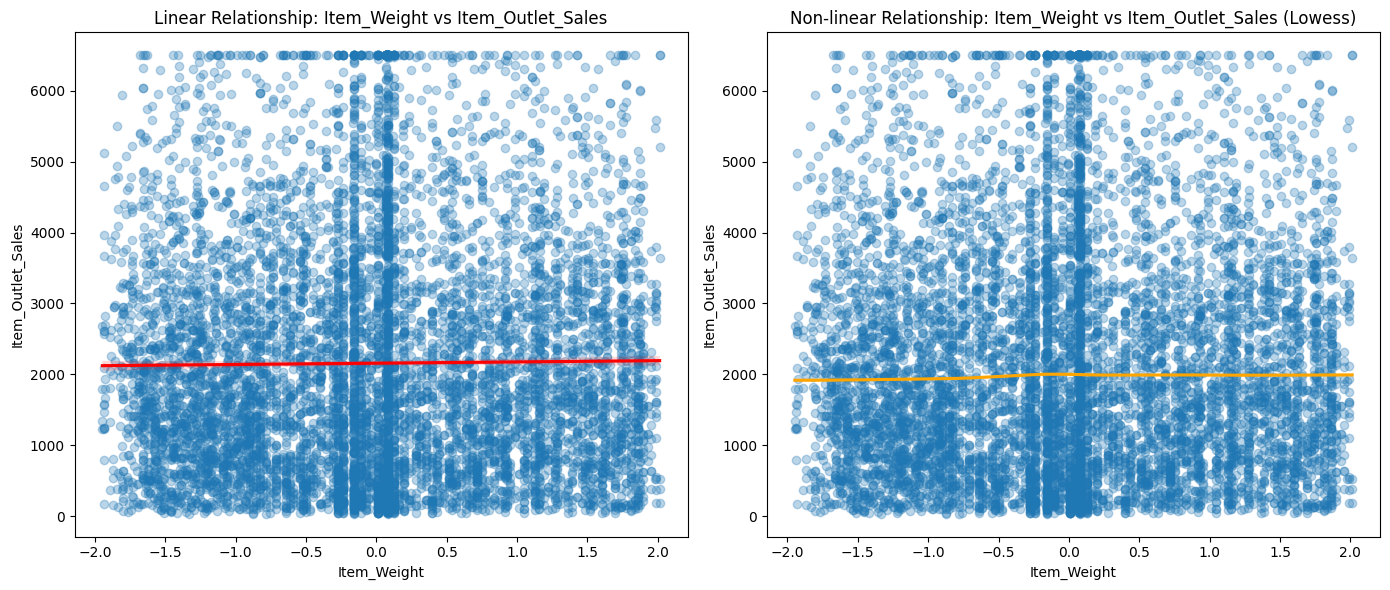

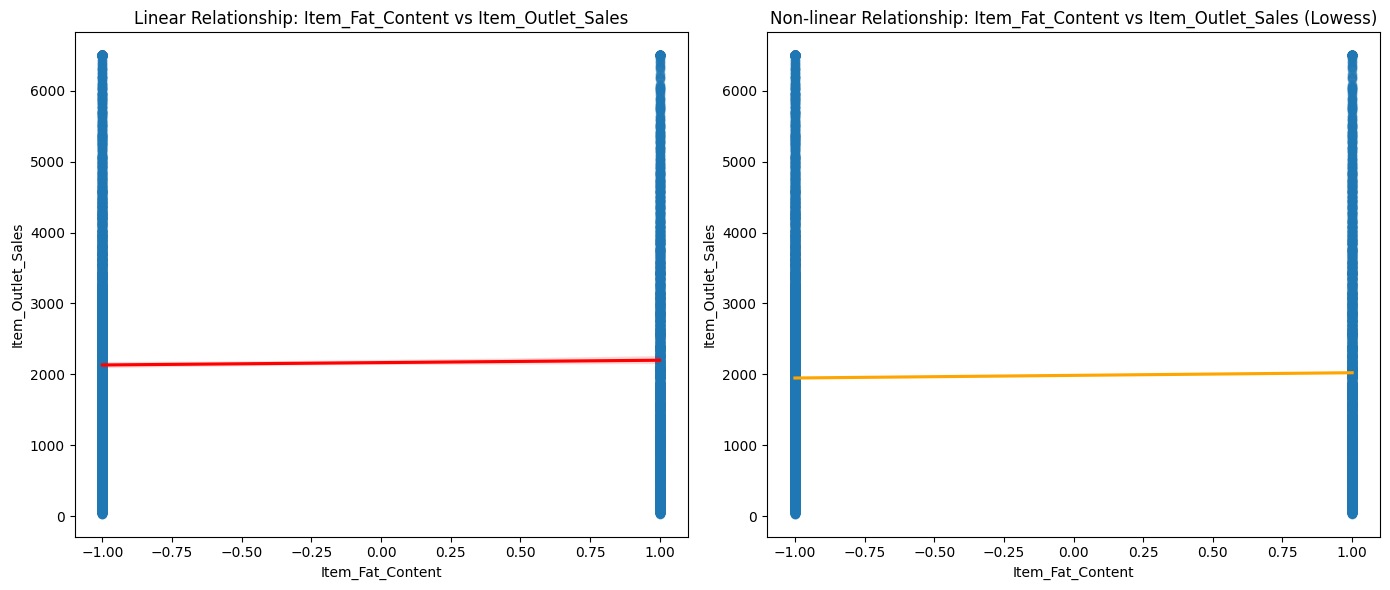

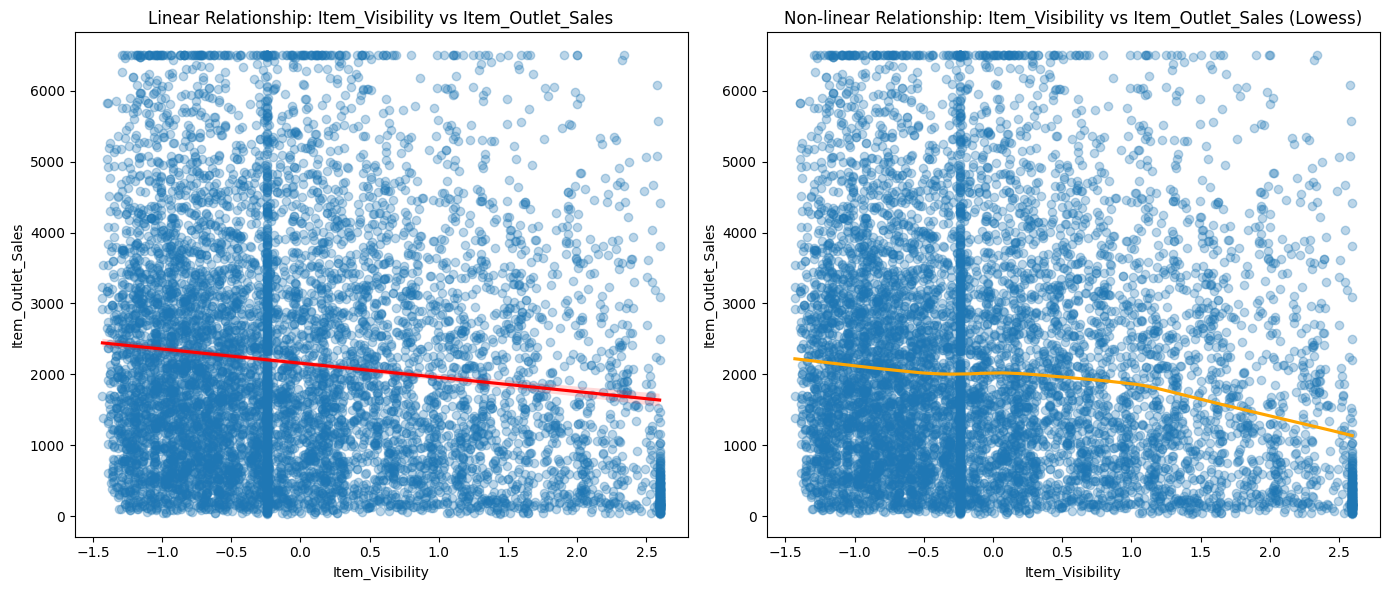

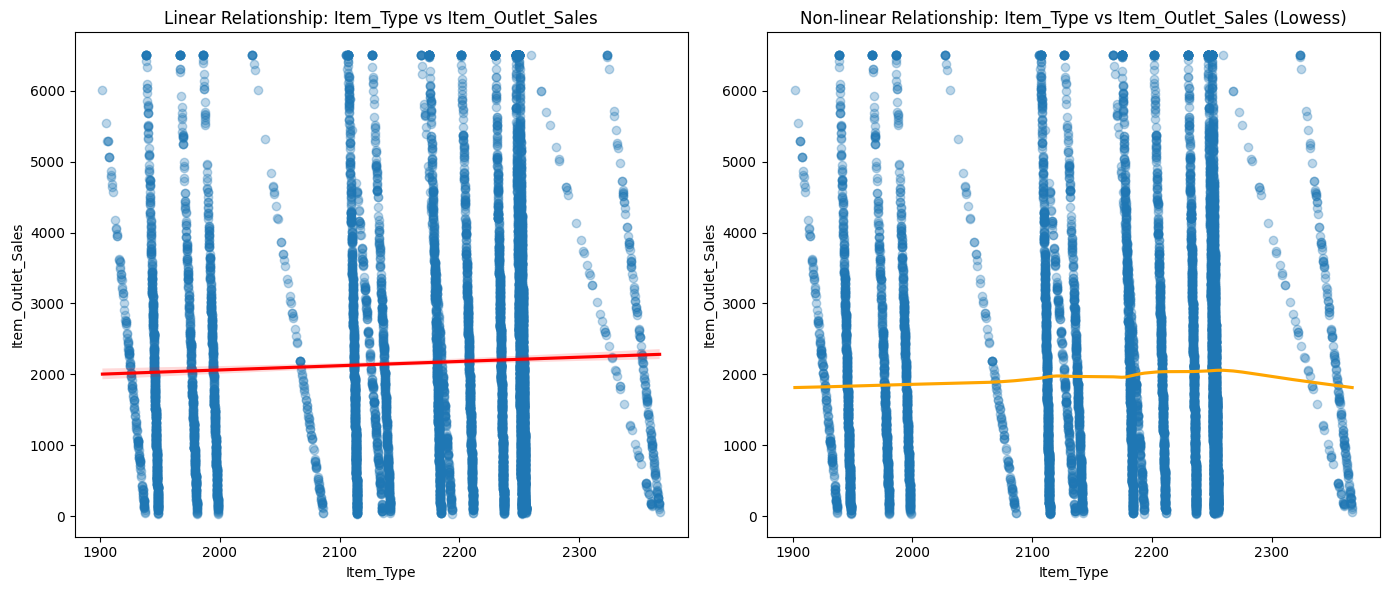

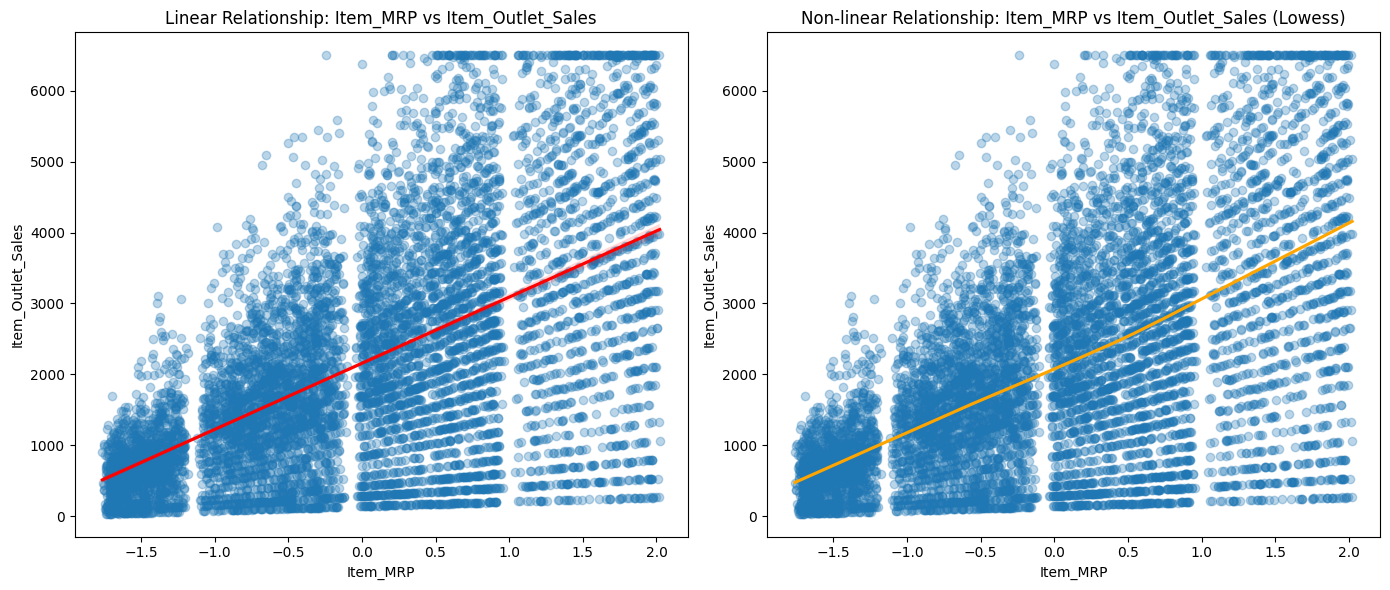

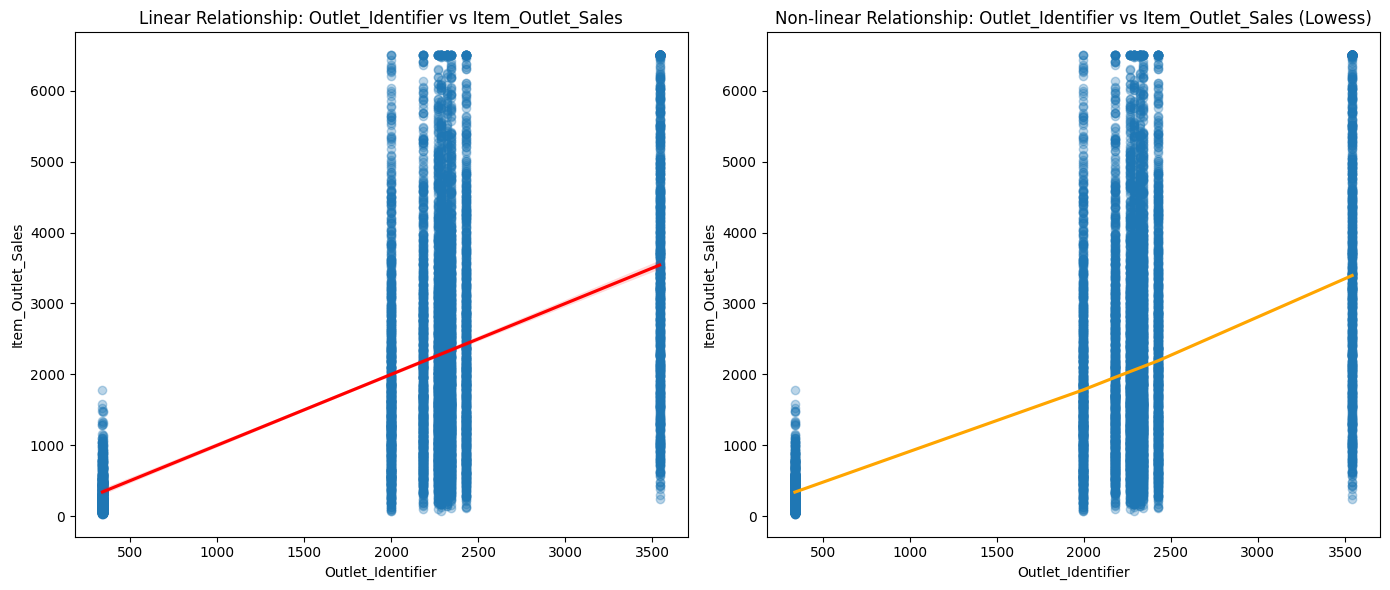

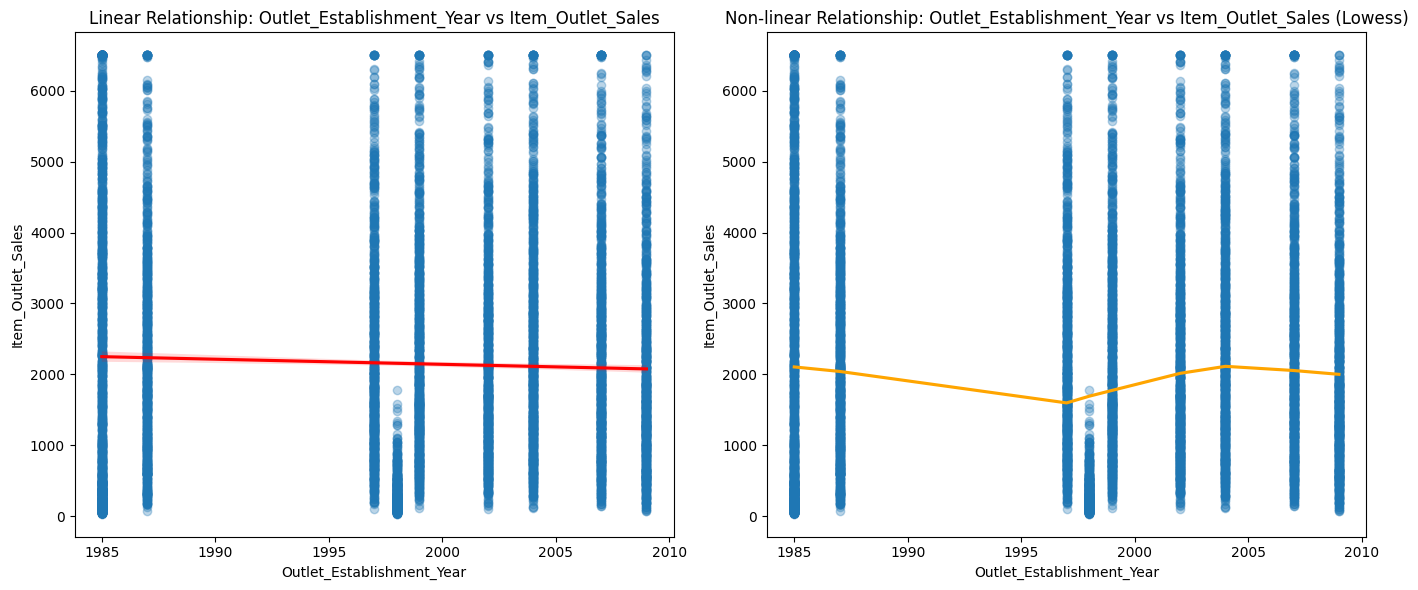

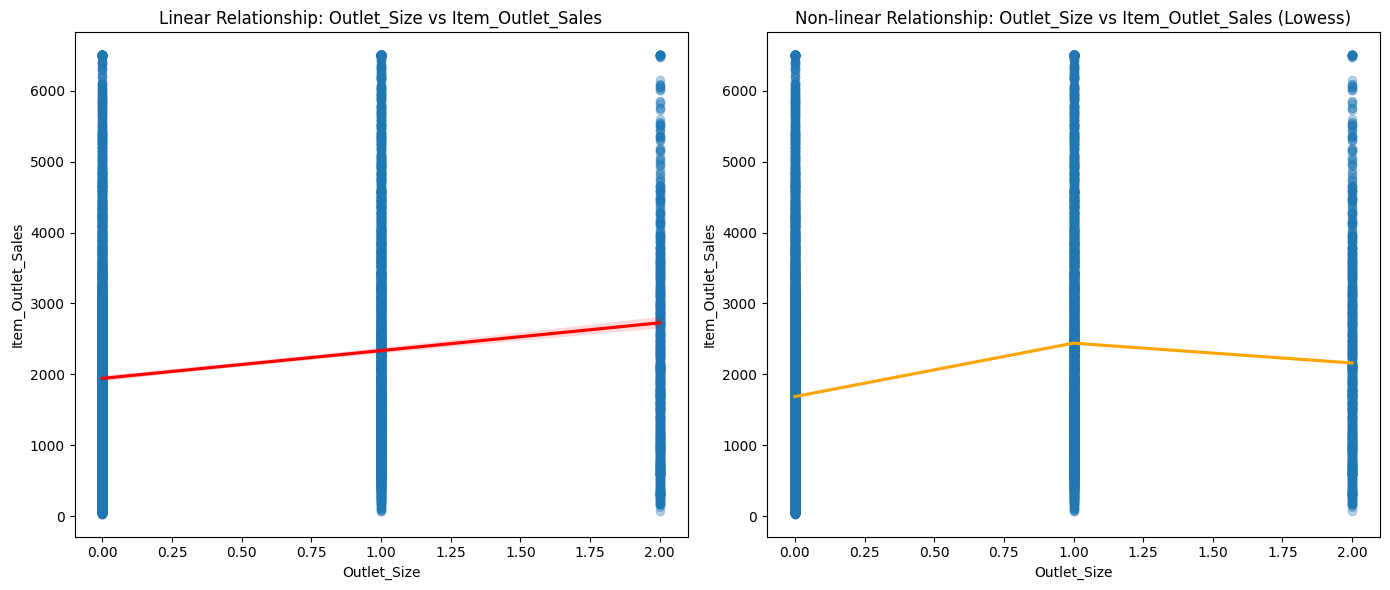

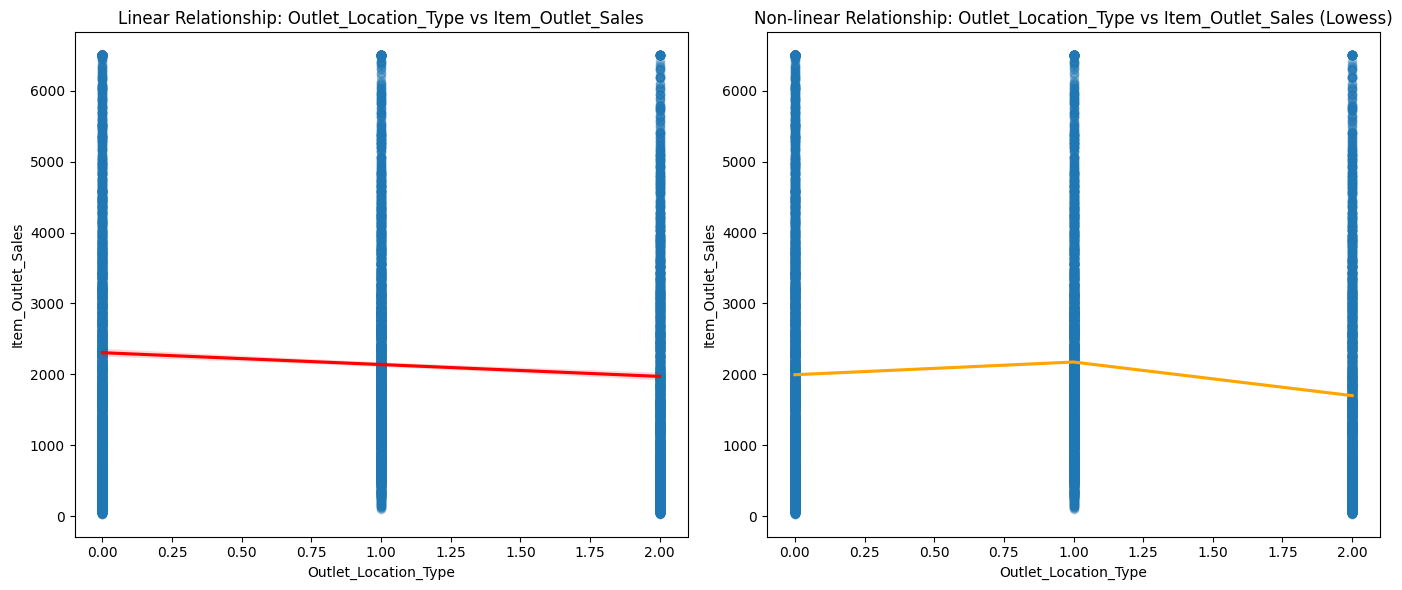

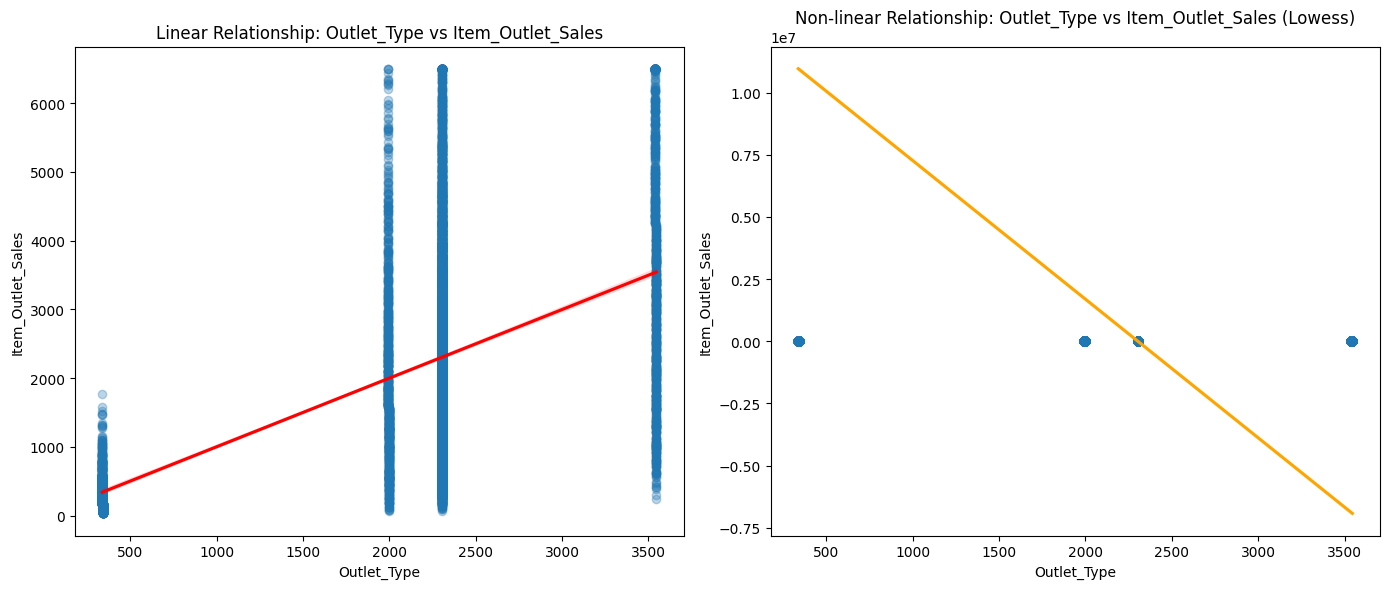

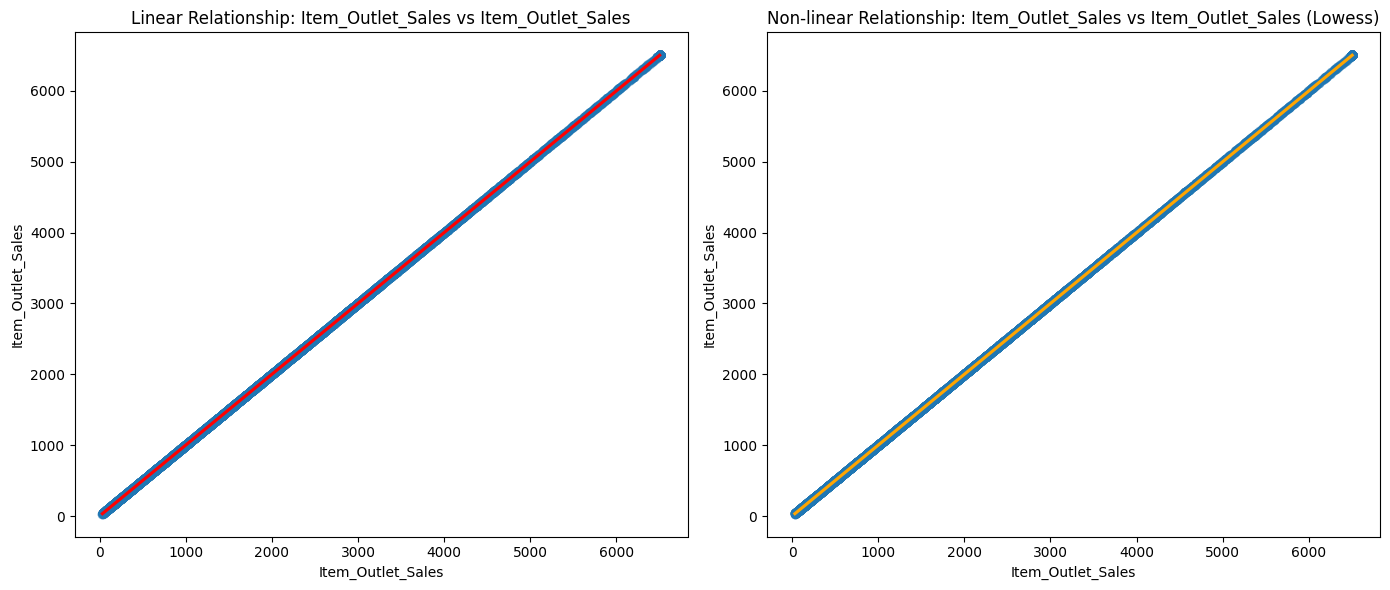

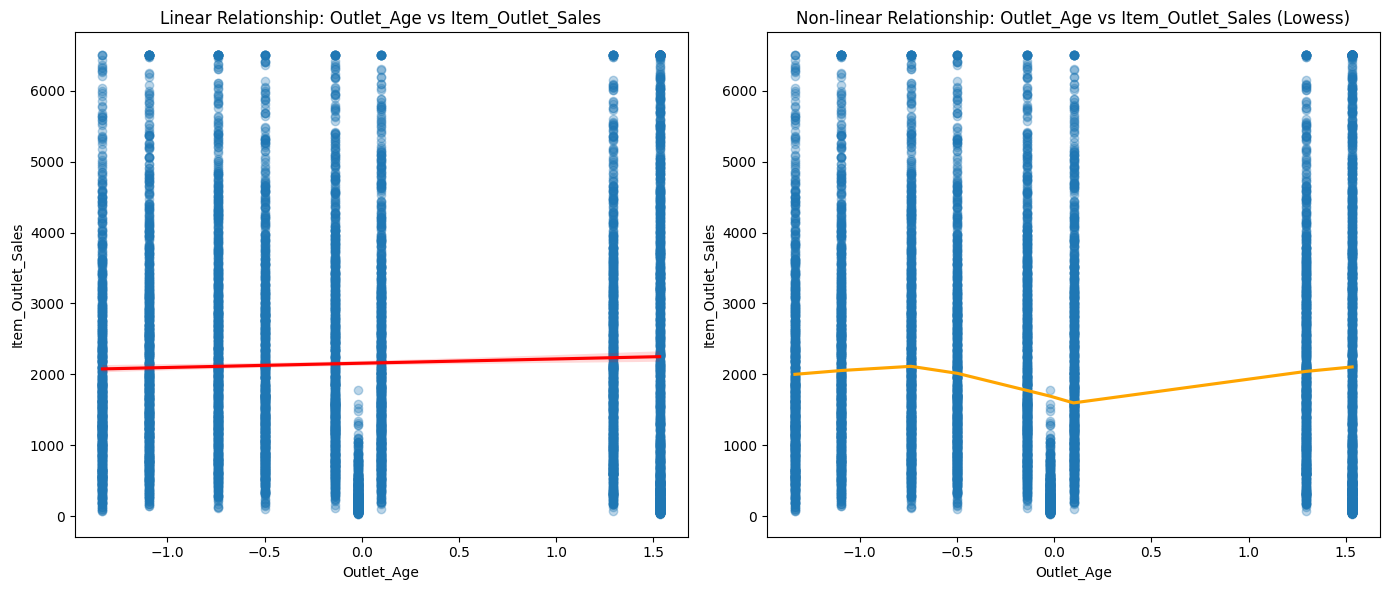

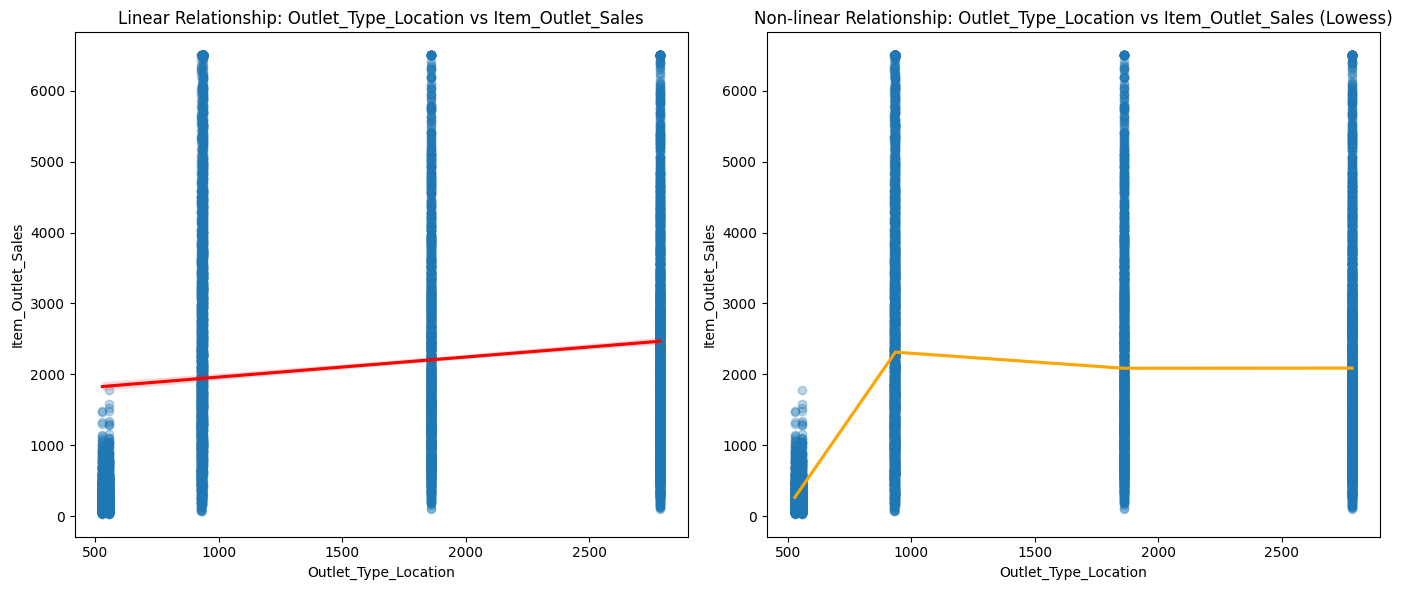

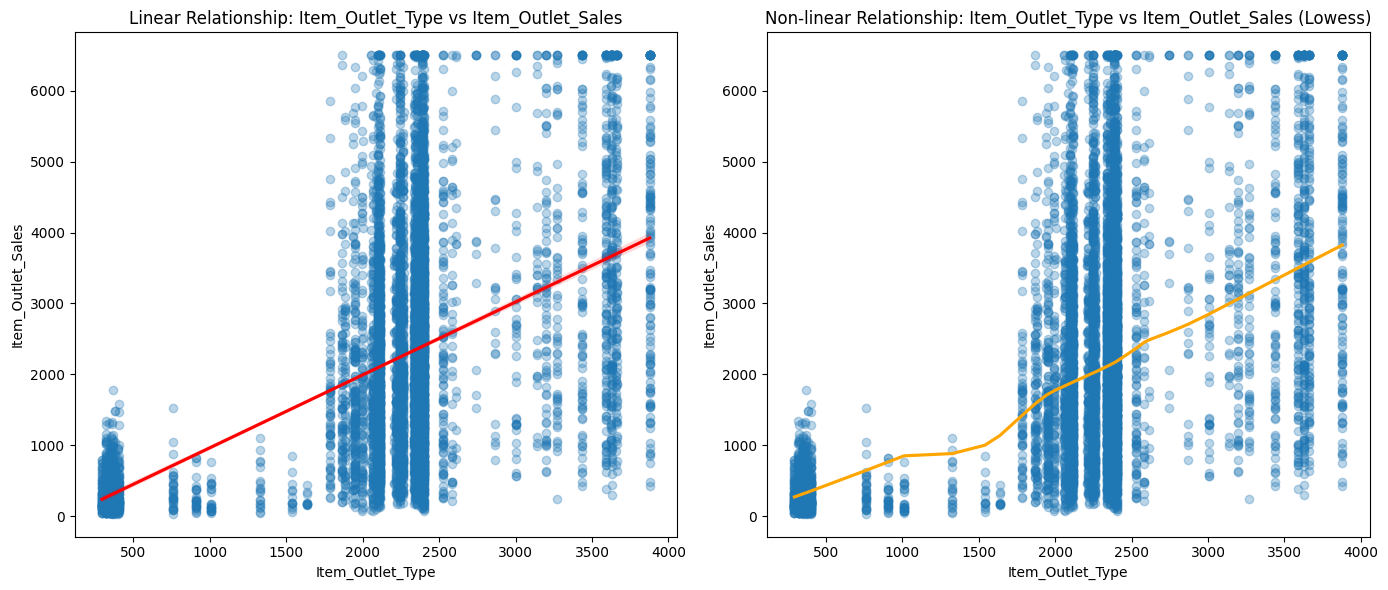

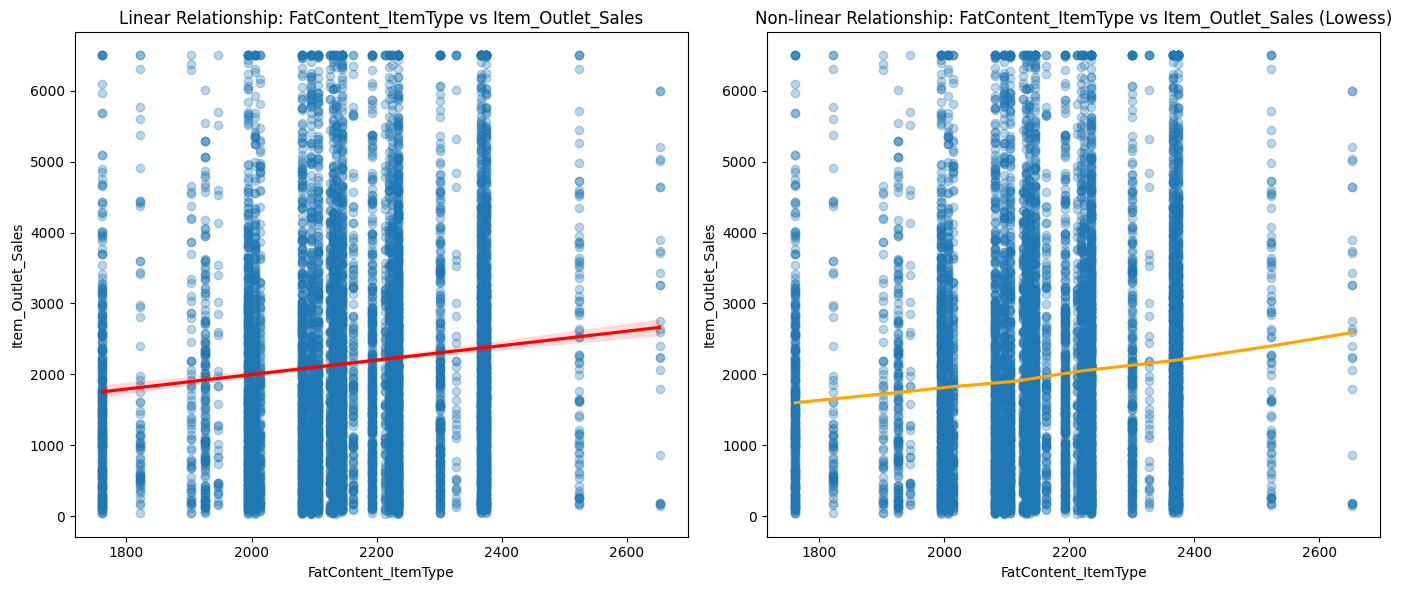

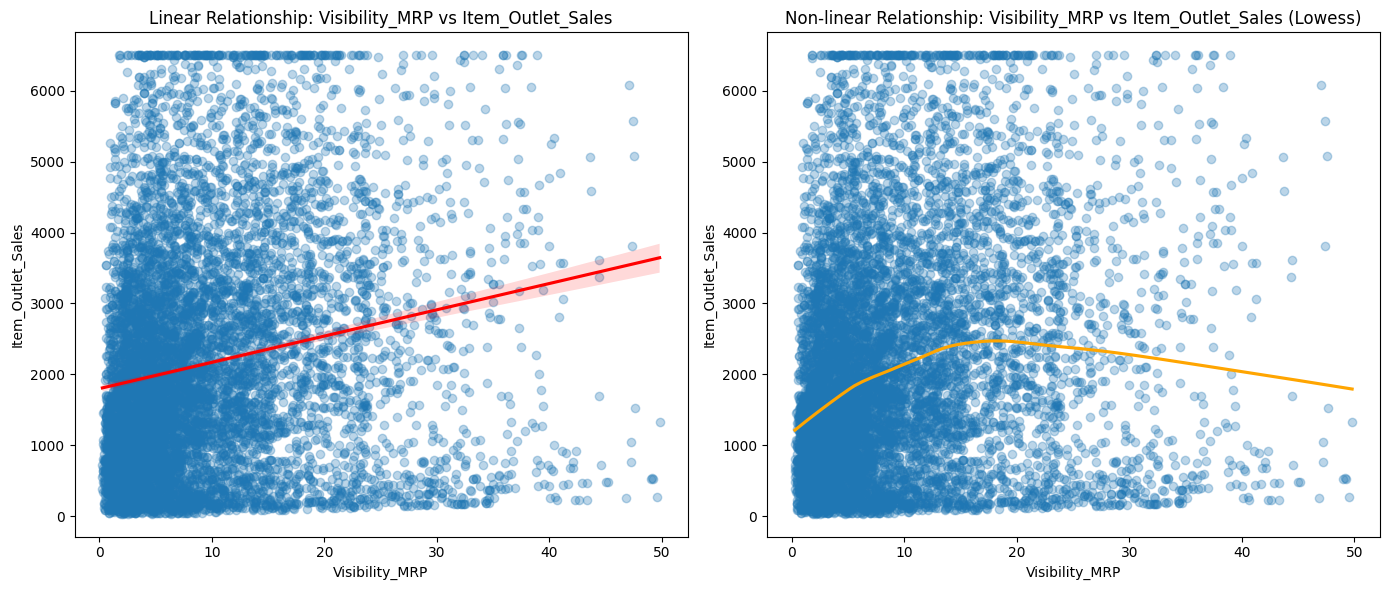

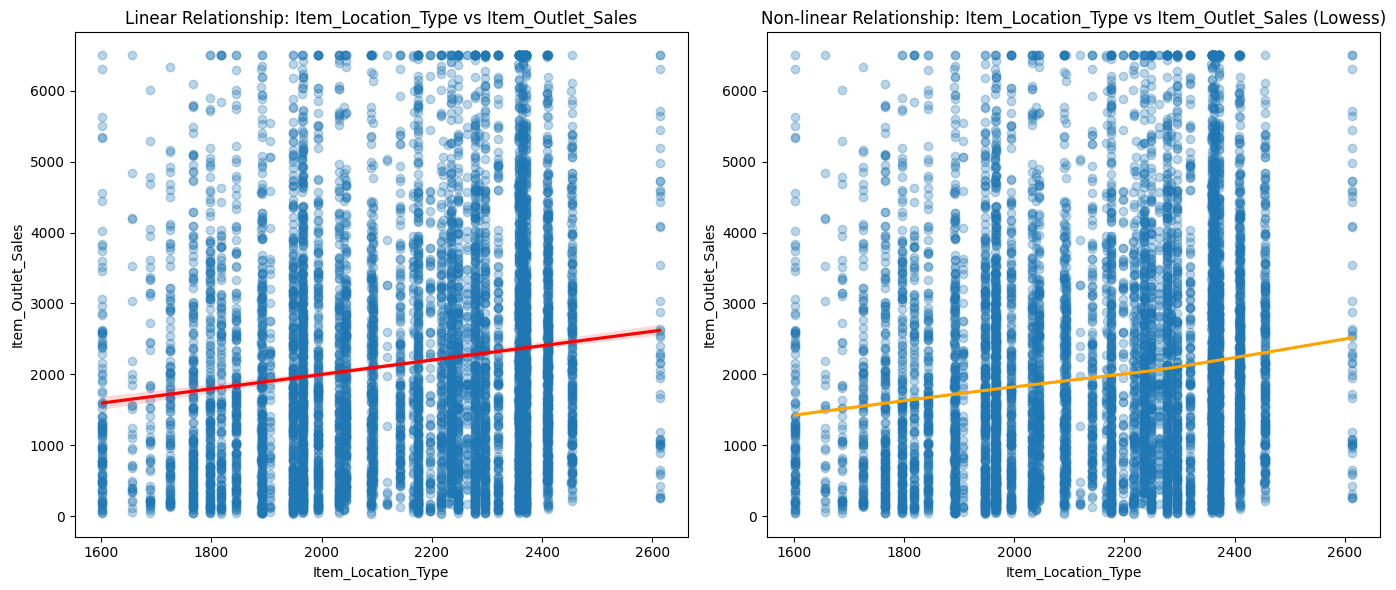

In [32]:
# Loop through each numeric column and plot scatter plots with linear and non-linear fits
for col in numeric_cols:
    plt.figure(figsize=(14, 6))

    # Scatter plot with linear regression
    plt.subplot(1, 2, 1)
    sns.regplot(x=col, y='Item_Outlet_Sales', data=df_cleaned, scatter_kws={'alpha':0.3}, line_kws={'color':'red'})
    plt.title(f'Linear Relationship: {col} vs Item_Outlet_Sales')
    plt.xlabel(col)
    plt.ylabel('Item_Outlet_Sales')

    # Scatter plot with lowess (non-linear) regression
    plt.subplot(1, 2, 2)
    sns.regplot(x=col, y='Item_Outlet_Sales', data=df_cleaned, scatter_kws={'alpha':0.3}, lowess=True, line_kws={'color':'orange'})
    plt.title(f'Non-linear Relationship: {col} vs Item_Outlet_Sales (Lowess)')
    plt.xlabel(col)
    plt.ylabel('Item_Outlet_Sales')

    plt.tight_layout()
    plt.show()

* Strong Predictors: Item_Identifier, Item_MRP, Outlet_Identifier, Outlet_Type, and Item_Outlet_Type show high linear relationships with Item_Outlet_Sales and should be prioritized for model inclusion.
* Potential Non-Linear Effects: Outlet_Type_Location, Outlet_Size, and Visibility_MRP exhibit non-linear relationships, indicating they might benefit from transformations or non-linear modeling approaches.
* Weak Predictors: Variables like Item_Weight, Item_Fat_Content, and Outlet_Age have limited association with Item_Outlet_Sales and may be less influential in predictive modeling.

# 6. **TARGET TRANSFORMATION :**

## 6.1 **Initial Distribution and Skewness Analysis**

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


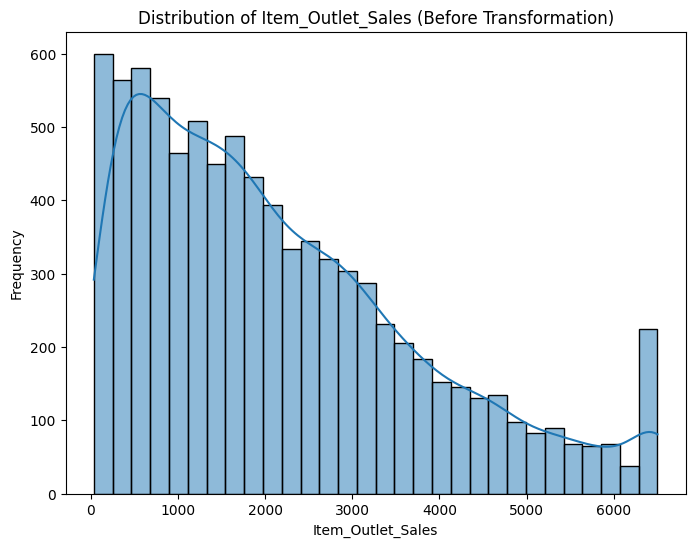

Skewness of Item_Outlet_Sales: 0.8746057192874345


In [33]:
# Plotting the distribution of the target variable
plt.figure(figsize=(8, 6))
sns.histplot(df_cleaned['Item_Outlet_Sales'], kde=True)
plt.title("Distribution of Item_Outlet_Sales (Before Transformation)")
plt.xlabel("Item_Outlet_Sales")
plt.ylabel("Frequency")
plt.show()

print("Skewness of Item_Outlet_Sales:", y.skew())

## 6.2 **Yeo-Johnson Transformation**

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


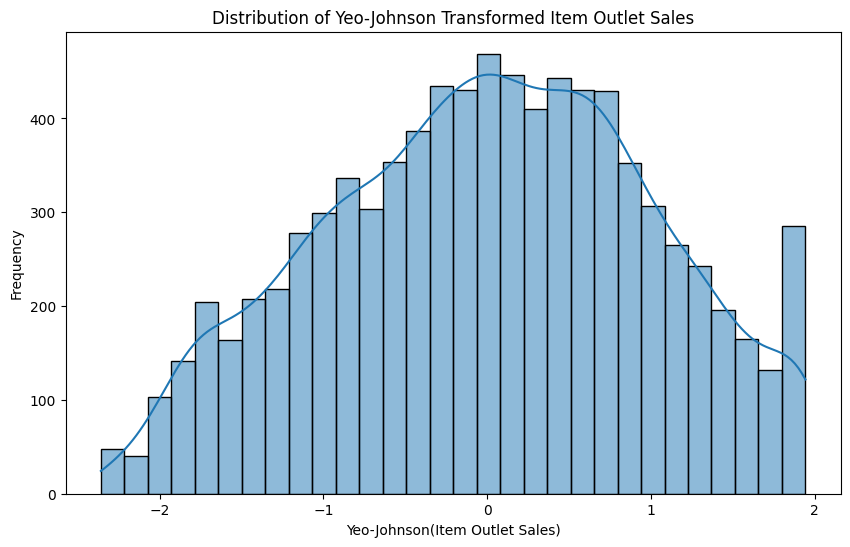

In [34]:
# Apply Yeo-Johnson transformation
pt = PowerTransformer(method='yeo-johnson')
df_cleaned['Item_Outlet_Sales'] = pt.fit_transform(df_cleaned[['Item_Outlet_Sales']])

# Plotting the distribution after Yeo-Johnson transformation
plt.figure(figsize=(10, 6))
sns.histplot(df_cleaned['Item_Outlet_Sales'], kde=True)
plt.title("Distribution of Yeo-Johnson Transformed Item Outlet Sales")
plt.xlabel("Yeo-Johnson(Item Outlet Sales)")
plt.ylabel("Frequency")
plt.show()

# 7. **FINAL DATA PREPARATION :**

## 7.1 **Checking for Non-Numeric Columns**

In [35]:
# Check the data types of your features
print(X.dtypes)

# Look for any non-numeric columns
non_numeric_cols = X.select_dtypes(include=['object']).columns
print("Non-numeric columns:", non_numeric_cols)


Item_Identifier              float64
Item_Weight                  float64
Item_Fat_Content             float64
Item_Visibility              float64
Item_Type                    float64
Item_MRP                     float64
Outlet_Identifier            float64
Outlet_Establishment_Year      int64
Outlet_Size                  float64
Outlet_Location_Type         float64
Outlet_Type                  float64
Outlet_Age                   float64
Outlet_Type_Location           int64
Item_Outlet_Type             float64
FatContent_ItemType          float64
Visibility_MRP               float64
Item_Location_Type           float64
dtype: object
Non-numeric columns: Index([], dtype='object')


## 7.2 **Numeric Column Analysis**

### 7.2.1 **Skewness and Kurtosis Analysis**

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

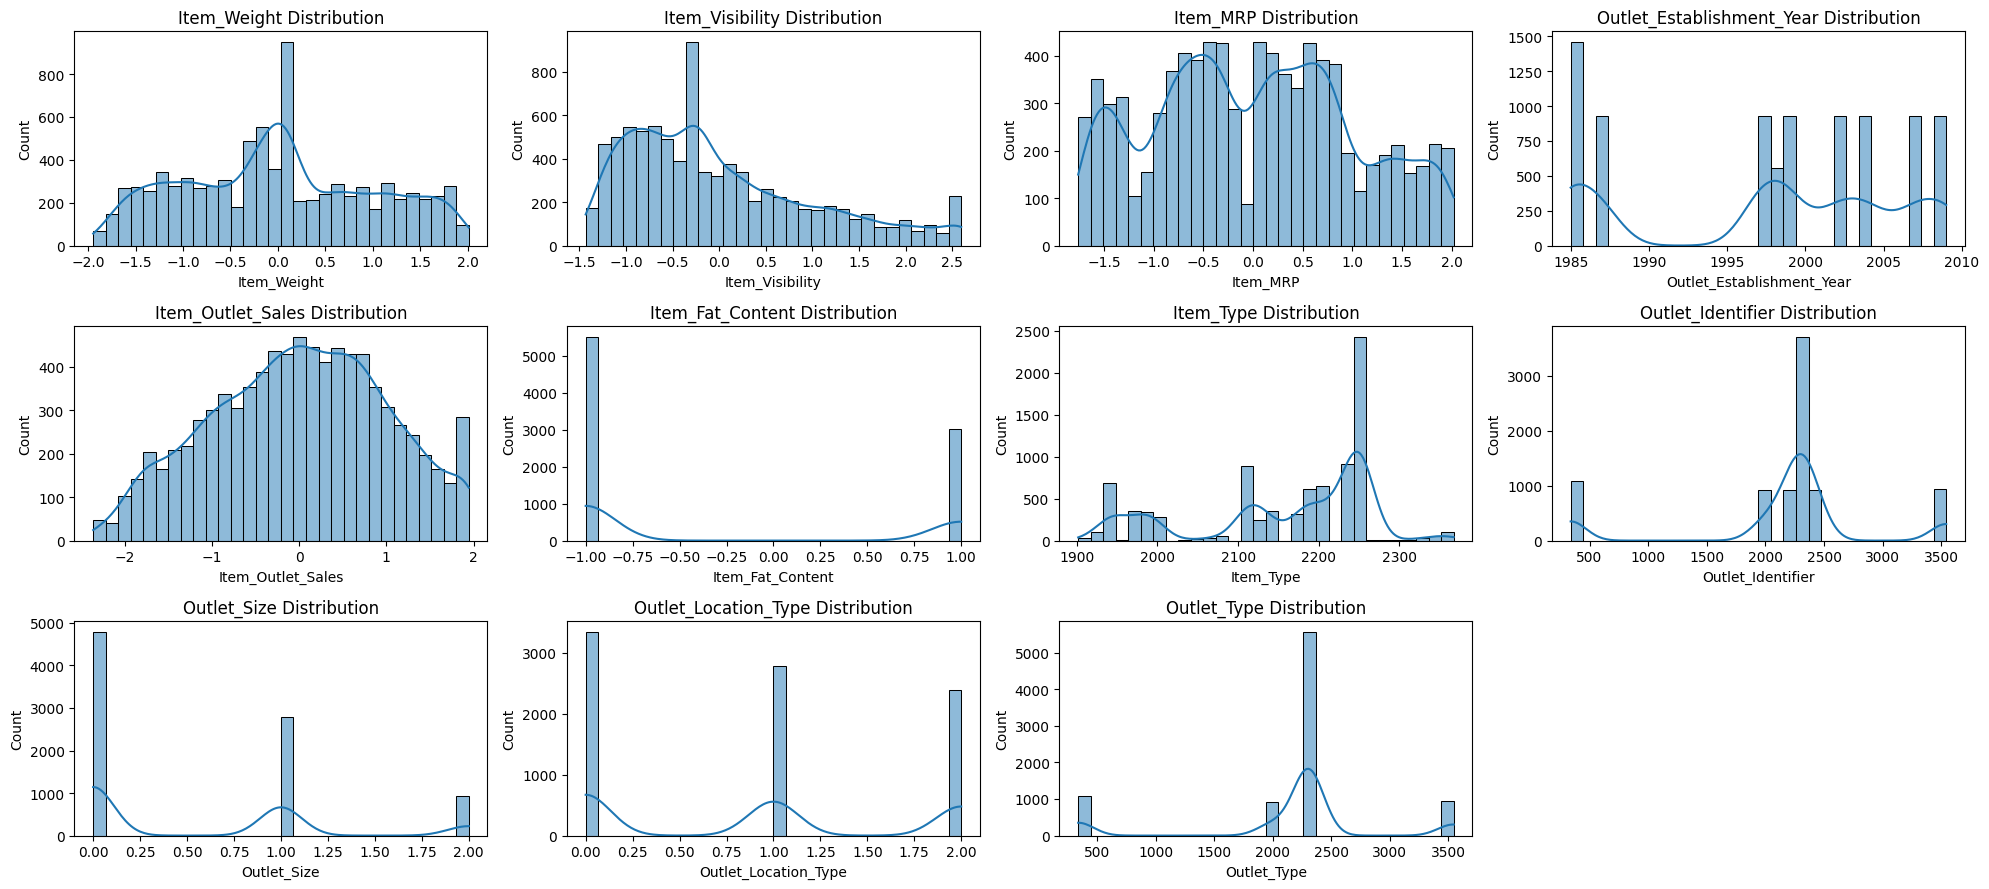

In [36]:
# Combine numerical and encoded categorical columns
all_features = numerical_cols + categorical_cols

# Create a FacetGrid for all features
n_cols = 4  # Number of columns in the grid
n_rows = (len(all_features) + n_cols - 1) // n_cols  # Calculate rows needed

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 3))
axes = axes.flatten()

for i, col in enumerate(all_features):
    sns.histplot(df_cleaned[col], kde=True, ax=axes[i], bins=30)
    axes[i].set_title(f'{col} Distribution')

# Remove empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

* Low Skewness: Most features have low skewness values, indicating a relatively symmetrical distribution, with exceptions like Visibility_MRP (1.50) and Item_Visibility (0.88), which are moderately skewed to the right.
* Kurtosis and Outliers: Many features have negative kurtosis (platykurtic) values, suggesting a distribution with lighter tails and fewer outliers, like Item_Weight (-0.89) and Outlet_Location_Type (-1.46). A few, such as Outlet_Identifier (2.52), exhibit higher kurtosis, indicating heavier tails and potential outliers.
* Implications for Normality: The moderate skewness and kurtosis for certain features (e.g., Visibility_MRP and Item_Visibility) may indicate non-normal distributions, which could be transformed or scaled for improved model performance.
* Symmetric Distributions: Features like FatContent_ItemType (-0.28) and Outlet_Establishment_Year (-1.21) are close to normal in skewness and kurtosis, suggesting they may not need much transformation.

In [37]:
# Function to transform skewed features using Yeo-Johnson
def transform_skewed_features(df_cleaned):
    # Calculate skewness
    skewness = df_cleaned.skew()
    skewness = skewness[abs(skewness) > 1]  # Filter for skewed features

    # Initialize the Yeo-Johnson transformer
    pt = PowerTransformer(method='yeo-johnson')

    for feature in skewness.index:
        df_cleaned[feature] = pt.fit_transform(df_cleaned[[feature]])  # Apply Yeo-Johnson transformation

    return df_cleaned

# Transform skewed features
transformed_df = transform_skewed_features(df_cleaned)

# Display the transformed DataFrame
print(transformed_df)

      Item_Identifier  Item_Weight  Item_Fat_Content  Item_Visibility  \
0         2860.403689    -0.828408              -1.0        -1.156923   
1         1900.318787    -1.625364               1.0        -1.085939   
2         2011.058374     1.105037              -1.0        -1.141263   
3         2327.375385     1.505873               1.0        -0.239783   
4         1859.116771    -0.915649              -1.0        -0.239783   
...               ...          ...               ...              ...   
8518      2405.433405    -1.402547              -1.0        -0.261949   
8519      2251.315189    -1.045331               1.0        -0.477277   
8520      1971.396107    -0.521886              -1.0        -0.736439   
8521      2138.794392    -1.321200               1.0         1.681020   
8522      1986.430886     0.468415              -1.0        -0.523505   

        Item_Type  Item_MRP  Outlet_Identifier  Outlet_Establishment_Year  \
0     2178.983018  1.747454        2341.687686